# 6 Diccionarios

El TDA Diccionario es uno de los más usados en la práctica, y se conocen mucha formas distintas de implementarlo.

Un Diccionario es un conjunto de $n$ elementos, cada uno de los cuales tiene un campo que permite identificarlo de manera única (ese campo se llama su *llave primaria*), sobre el cual están definidas las operaciones de buscar, insertar, eliminar, y ocasionalmente otras que definiremos más adelante.
Más precisamente, si $d$ es un diccionario, existirán las operaciones:

* `r=d.search(x)`: buscar el elemento de llave `x`, retornar un resultado que permita ubicarlo, o `None` si no está
* `d.insert(x)`: insertar un elemento de llave `x`, evitando crear una llave duplicada
* `d.delete(x)`: eliminar el elemento de llave `x`, el cual debe estar en el diccionario

## Diccionarios de Python

El lenguaje Python posee un tipo `dict` que implementa la funcionalidad de diccionarios que hemos descrito (más operaciones adicionales). En un diccionario se busca por una llave y se obtiene un valor asociado.

In [11]:
distancia = {'Valparaíso':102, 'Concepción': 433, 'Arica': 1664, 'Puerto Montt': 912, 'Rancagua': 80}

La forma de buscar es simplemente usando la llave como subíndice:

In [12]:
print(distancia['Arica'])

1664


Y la forma de agregar una nueva llave es asignándole un valor:

In [13]:
distancia['Talca']=237

Al buscar una llave inexistente se produce una excepción:

In [14]:
print(distancia['La Serena'])

KeyError: 'La Serena'

Pero hay una forma de buscar sin que dé un error, sino que retorne `None`:

In [15]:
print(distancia.get('Rancagua'), distancia.get('La Serena'))

80 None


Para eliminar un dato, se usa `pop` (lo elimina y retorna su valor):

In [16]:
distancia.pop('Rancagua')

80

Aparte de esto, hay muchas otras operaciones que permiten obtener la lista de todas las llaves, etc.

Dado que en Python ya existe una implementación de diccionarios, ¿por qué querríamos estudiar nosotros cómo implementarlos?

La respuesta está en que, si nosotros controlamos todos los detalles de una implementación, sabremos exactamente cuan eficiente es, y para qué tipo de aplicaciones es más apropiada. Lo último es particularmente importante, porque no hay ninguna implementación de diccionarios que sea uniformemente mejor que las otras para todas las aplicaciones.

Estudiaremos entonces cómo se puede implementar un diccionario, comenzando por las estrategias más sencillas, y avanzando hacia enfoques más sofisticados.

En nuestros ejemplos supondremos que solo almacenamos la llave, pero en la práctica siempre habrá información adicional asociada a cada llave. También por simplicidad a menudo usaremos llaves numéricas, aunque en la práctica es más frecuente que las llaves sean strings.

## Búsqueda secuencial

La manera más simple de implementar un diccionario es con una lista desordenada de llaves, en la cual se hace búsqueda secuencial. La inserción es especialmente eficiente si obviamos chequear por duplicados, y la eliminación es eficiente una vez que sabemos dónde está la llave.

In [2]:
import numpy as np

In [20]:
class Lista_secuencial:
    def __init__(self, size=100):
        self.a=np.zeros(size,dtype=int)
        self.n=0
    def insert(self,x):
        assert self.n<len(self.a)
        self.a[self.n]=x
        self.n+=1
    def search(self,x):
        for k in range(0,self.n):
            if self.a[k]==x:
                return k
        return None
    def delete(self,x):
        k=self.search(x)
        self.a[k]=self.a[self.n-1] # movemos el último al lugar vacante
        self.n-=1

In [22]:
d=Lista_secuencial()
d.insert(30)
d.insert(10)
d.insert(25)
print(d.search(10))
print(d.search(80))
d.delete(30)
print(d.search(30))

1
None
None


La búsqueda secuencial también se puede implementar con una lista enlazada, en cuyo caso será más simple insertar al inicio.

En cualquier caso, la búsqueda demora tiempo $\Theta(n)$.
Para estimar el costo promedio, suponemos que todos los elementos son igualmente probables de ser accesados y que el costo de buscar a un elemento que es el $k$-ésimo de la lista es $k$. Por lo tanto, el costo promedio es

$$
\frac{1}{n}\sum_{1\le k \le n} k = \frac{n+1}{2}=\Theta(n)
$$

Por lo tanto, este tipo de implementación solo será adecuada para conjuntos muy pequeños.

## Búsqueda secuencial con probabilidades de acceso no uniformes

En la práctica, es muy raro que las probabilidades de acceso a los elementos sean uniformes. Con frecuencia hay algunos elementos que son mucho más populares que otros, y empíricamente a menudo se observan distribuciones de tipo "ley de potencias", con probabilidades de tipo

$$
p_k \propto \frac{1}{k^{\alpha}}
$$

para algún $\alpha$. Para el caso $\alpha=1$ esto se llama Ley de Zipf.

Si un conjunto de datos tiene elementos con probabilidades de acceso diferentes, entonces para la búsqueda secuencial el orden en que estén los elementos en la lista hace una diferencia.

### Caso 1. Probabilidades conocidas

Si las probabilidades de acceso son conocidas, es fácil ver que el orden óptimo es en orden decreciente de probabilidad.

Más precisamente, si los elementos son $X_1, X_2,\ldots,X_n$ con probabilidades de acceso $p_1,p_2,\ldots,p_n$ respectivamente, y si están ordenados de modo que $p_1\ge p_2\ge p_3\ge \cdots$, entonces el costo esperado de búsqueda óptimo es

$$
C_{OPT} = \sum_{1\le k\le n} k p_k
$$

Tomemos como ejemplo el capítulo 1 de "El Quijote" (en minúsculas y sin puntuación para simplificar su proceso), cuyo texto está en el archivo `cap1.txt`:

```
en un lugar de la mancha de cuyo nombre no quiero acordarme no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero adarga antigua
...
peregrino y significativo como todos los demás que a él y a sus cosas
había puesto
```

#### Acceso al archivo desde Colab

Si este notebook está usándose en Google Colab, el archivo se debe almacenar en la carpeta `Colab Notebooks` de Google Drive, y para que el código en Python pueda tener acceso a él se debe quitar los comentarios y ejecutar la siguiente celda: 

In [150]:
#from google.colab import drive
#drive.mount("/content/gdrive")
#%cd "/content/gdrive/My Drive/Colab Notebooks/"

El costo óptimo para un archivo dado se puede obtener con el siguiente código en Python, en el cual hacemos uso de los diccionarios provistos por el lenguaje:

In [160]:
def calcula_costo_optimo(archivo): # lee el archivo, calcula frecuencias en orden descendente
    f=open(archivo,"r")
    texto=f.read()
    palabras=texto.split()
    frec={}
    for x in palabras:
        frec[x] = 1 if not x in frec else frec[x]+1
    lista=[]
    Copt=0
    costo=0
    for x in sorted(frec,key=frec.get,reverse=True):
        costo+=1
        Copt+=costo*frec[x]
        lista.append((frec[x],x))
    Copt/=len(palabras)
    f.close()
    return (Copt,lista)

Como resultado, mostramos el costo esperado de búsqueda en una lista ordenada de manera óptima (C_OPT) y las palabras más frecuentes:

In [170]:
(c,L)=calcula_costo_optimo("cap1.txt")
print('C_OPT={:6.2f}\n'.format(c))
for k in range(0,9):
    print(L[k])

C_OPT=157.81

(120, 'de')
(105, 'y')
(88, 'que')
(44, 'a')
(40, 'el')
(38, 'en')
(35, 'su')
(33, 'la')
(30, 'se')


### Caso 2: Probabilidades desconocidas

Cuando las probabilidades son desconocidas, existen estrategias adaptativas, que van reordenando la lista dinámicamente a medida que los elementos son buscados, de modo de tratar de aproximar el orden óptimo. Hay dos técnicas que dan buenos resultados: "traspose" (TR) y "move to front" (MTF).

### Transpose

Esta técnica consiste en que cada vez que un elemento es accesado, se le mueve un lugar más adelante en la lista (a menos que ya esté en el primer lugar).
Esto se puede implementar ya sea en un arreglo o en una lista enlazada. En la siguiente implementación usaremos una lista enlazada con cabecera.

Si un elemento no se encuentra, simulamos como si hubiese estado al final de la lista. Para esto, mantendremos siempre disponible un nodo extra al final de la lista, en donde almacenaremos tentativamente la llave de búsqueda.
Si finalmente se encuentra en ese nodo, se le incorpora a la lista y se crea un nuevo nodo extra.

Para contabilizar el costo, el método `search` retorna el número de comparaciones de llaves que se hizo en la búsqueda.

In [129]:
class NodoLista:
    def __init__(self,info,sgte=None):
        self.info=info
        self.sgte=sgte
        
class Lista_TR:
    def __init__(self):
        self.extra=NodoLista(0)
        self.cabecera=NodoLista(0,self.extra)
        
    def search(self,x): # busca x (si no está lo inserta al final) y lo adelanta un lugar
                        # retorna el costo de búsqueda
        self.extra.info=x # agregamos x al final, en caso que no estuviera antes
        p=self.cabecera
        q=p.sgte
        
        # k cuenta el número de comparaciones de llaves
        if q.info==x: # x ya está primero en la lista, no hacemos nada
            k=1
        else:
            # buscamos del segundo en adelante
            r=q.sgte
            k=2
            while r.info!=x:
                (p,q,r)=(q,r,r.sgte)
                k+=1
            # r apunta al elemento buscado, lo movemos un lugar hacia adelante
            (p.sgte,q.sgte,r.sgte)=(r,r.sgte,q)
        if q.sgte is None: # se utilizó el nodo extra, agregamos uno nuevo
            self.extra=NodoLista(0)
            q.sgte=self.extra
        return k

    def imprimir(self):
        p=self.cabecera.sgte
        print("[",end=" ")
        while p is not self.extra:
            print(p.info,end=" ")
            p=p.sgte
        print("]")

In [130]:
def test(Lista_adaptativa): # test interactivo
    a=Lista_adaptativa()
    while True:
        x=input("x=")
        if x=="fin":
            return
        print("costo=",a.search(x),end=" ")
        a.imprimir()

In [131]:
test(Lista_TR)

x=hola
costo= 1 [ hola ]
x=chao
costo= 2 [ chao hola ]
x=casa
costo= 3 [ chao casa hola ]
x=hola
costo= 3 [ chao hola casa ]
x=hola
costo= 2 [ hola chao casa ]
x=hola
costo= 1 [ hola chao casa ]
x=gato
costo= 4 [ hola chao gato casa ]
x=fin


In [171]:
def procesa(archivo,Lista_adaptativa): # lee el archivo y calcula costo promedio de búsqueda
    f=open(archivo,"r")
    texto=f.read()
    palabras=texto.split()
    npalabras=0
    costo_acum=0
    a=Lista_adaptativa()
    for x in palabras:
        costo_acum+=a.search(x)
        npalabras+=1
    print("Costo promedio de búsqueda= {:6.2f}".format(costo_acum/npalabras))
    f.close()

In [172]:
procesa("cap1.txt",Lista_TR)

Costo promedio de búsqueda= 208.74


### Move-To-Front

Esta técnica consiste en que cada vez que un elemento es accesado, se le mueve al primer lugar de la lista (a menos que ya esté en el primer lugar). Si un elemento no se encuentra, simulamos como si hubiese estado al final de la lista.

In [138]:
class Lista_MTF:
    def __init__(self):
        self.extra=NodoLista(0)
        self.cabecera=NodoLista(0,self.extra)
        
    def search(self,x): # busca x (si no está lo inserta al final) y luego lo mueve al primer lugar
        # retorna el costo de búsqueda
        self.extra.info=x # agregamos x al final, en caso que no estuviera antes
        p=self.cabecera
        q=p.sgte
        k=1 # cuenta el número de comparaciones de llaves
        while q.info!=x:
            (p,q)=(q,q.sgte)
            k+=1
        if q.sgte is None: # se utilizó el nodo extra, agregamos uno nuevo
            self.extra=NodoLista(0)
            q.sgte=self.extra
        if k>1:  # x no está primero, move to front
            (self.cabecera.sgte,p.sgte,q.sgte)=(q,q.sgte,self.cabecera.sgte)         
        return k

    def imprimir(self):
        p=self.cabecera.sgte
        print("[",end=" ")
        while p is not self.extra:
            print(p.info,end=" ")
            p=p.sgte
        print("]")

In [139]:
test(Lista_MTF)

x=hola
costo= 1 [ hola ]
x=casa
costo= 2 [ casa hola ]
x=chao
costo= 3 [ chao casa hola ]
x=hola
costo= 3 [ hola chao casa ]
x=casa
costo= 3 [ casa hola chao ]
x=casa
costo= 1 [ casa hola chao ]
x=gato
costo= 4 [ gato casa hola chao ]
x=fin


In [173]:
procesa("cap1.txt",Lista_MTF)

Costo promedio de búsqueda= 188.82


En resumen, tenemos que para este texto en particular, el costo óptimo es 157.81, el costo promedio de TR es 208.74 y el de MTF es 188.82.

Si en lugar de considerar un caso se analiza matemáticamente el caso general, suponiendo que los accesos llegan independientemente siguiendo la distribución dada y que el algoritmo corre durante un tiempo que tiende a infinito, se puede demostrar que

$$
C_{OPT} \le C_{TR} \le C_{MTF} \le \frac{\pi}{2} C_{OPT}
$$

## Búsqueda en un arreglo ordenado: Búsqueda Binaria

Ya hemos visto anteriormente que si los datos están en un arreglo ordenado, podemos hacer una búsqueda binaria, la que demora tiempo $\lceil\log_2{(n+1)}\rceil=\Theta(\log{n})$ en el peor caso.

Esto es bastante eficiente, pero tiene el problema que agregar o eliminar datos del arreglo toma tiempo $\Theta(n)$ en el peor caso, por la necesidad de mantener el conjunto ordenado y compacto.
Un objetivo que perseguiremos en el resto de este capítulo es tratar de encontrar estructuras de datos que nos permitan buscar de manera tan eficiente como la búsqueda binaria, junto con inserciones y eliminaciones igualmente eficientes.

Pero antes de avanzar en esa dirección, consideremos la pregunta de si es posible buscar má rápido que la búsqueda binaria en el peor caso.

### Cota inferior para la búsqueda por comparaciones

Consideremos el problema de buscar una llave $x$ en un conjunto de tamaño 4, digamos $\{a,b,c,d\}$, con $a<b<c<d$. La siguiente figura ilustra una manera como podría hacerse esa búsqueda:

![decision-tree](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/decision-tree.png?raw=1)

Este tipo de figura se llama un *árbol de decisión*, y en él los rombos representan preguntas y los rectángulos, las salidas (outputs) del algoritmo.

Este árbol de decisión es uno entre la infinidad de árboles que podrían resolver el problema de la búsqueda. Lo importante que hay que observar es que todo algoritmo que funcione mediante comparaciones binarias (comparaciones con salidas "Sí/No") se puede representar por un árbol de decisión.

En este tipo de árbol tenemos que:

* La altura representa el número de comparaciones que hace el algoritmo en el peor caso, y
* El número de hojas (cajas rectangulares) debe ser mayor o igual al número de respuestas posibles que debe ser capaz de emitir el algoritmo.

Recordemos que si $N$ es el número de hojas y $h$ la altura, siempre se tiene $N\le 2^h$, de donde se deduce que
$h \ge \lceil\log_2{N}\rceil$ (porque la altura es un número entero), y en consecuencia, tenemos que

$$
\text{Peor caso} \ge \lceil\log_2{(\text{número de respuestas distintas})}\rceil
$$

Para el caso de la búsqueda binaria, tenemos que $N=n+1$, porque el algoritmo de búsqueda debe poder identificar a cada uno de los $n$ elementos, más la respuesta negativa cuando el elemento buscado no está. En consecuencia:

**Todo algoritmo que busque en un conjunto de tamaño $n$ mediante comparaciones binarias debe hacer al menos
$\lceil\log_2{(n+1)}\rceil$ comparaciones en el peor caso.**

Por lo tanto, la búsqueda binaria es óptima.

## Árboles de Búsqueda Binaria (ABBs)

Un *árbol de búsqueda binaria* (*ABB*) es un árbol binario en que todos sus nodos internos cumplen la siguiente propiedad: Si la llave almacenada en el nodo es $x$, entonces todas las llaves en su subárbol izquierdo son menores que $x$, y las llaves en el subárbol derecho son mayores que $x$.

![esquema-ABB2](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/esquema-ABB2.png?raw=1)

Los ABBs permiten realizar de manera eficiente (en promedio) las operaciones de inserción y búsqueda.

### Búsqueda en un ABB

La búsqueda es similar a una búsqueda binaria (de  ahí el nombre de estos árboles). Para buscar una llave $x$ se comienza en la raíz. Si $x$ se encuentra ahí, la búsqueda termina exitosamente. Si no está ahí, se continúa buscando  en el subárbol izquierdo si $x$ es menor que la raíz, o en el subárbol derecho si $x$ es mayor que la raíz. Si se llega a una hoja (nodo externo), la búsqueda concluye infructuosamente.

### Inserción en un ABB

Para insertar una llave $x$ en un ABB, se realiza una búsqueda, que debe ser infructuosa, y la hoja en donde termina la búsqueda se reemplaza por un nodo interno conteniendo la llave $x$, con dos nuevas hojas como hijos.

![insercioABB](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/insercionABB.gif?raw=1)

### Implementación recursiva

Los algoritmos de un ABB se prestan de manera natural a ser programados de manera recursiva, especialmente con la representación explícita de los nodos externos:

In [1]:
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
        
    def search(self,x):
        if x==self.info:
            return self
        if x<self.info:
            return self.izq.search(x)
        else:
            return self.der.search(x)
        
    def insert(self,x):
        assert x!=self.info
        if x<self.info:
            return Nodoi(self.izq.insert(x),self.info,self.der)
        else:
            return Nodoi(self.izq,self.info,self.der.insert(x))
        
    def __str__(self):
        return "("+self.izq.__str__()+str(self.info)+self.der.__str__()+")"

class Nodoe:
    def __init__(self):
        pass
    
    def search(self,x):
        return None
    
    def insert(self,x):
        return Nodoi(Nodoe(),x,Nodoe())
    
    def __str__(self):
        return"☐"

class Arbol:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz     
        
    def insert(self,x):
        self.raiz=self.raiz.insert(x)
        
    def search(self,x):
        return self.raiz.search(x)
    
    def __str__(self):        
        return self.raiz.__str__()

Hemos incluído una función `__str__` para poder visualizar (de forma algo rudimentaria) el árbol construído.

In [2]:
a=Arbol()
a.insert(42)
a.insert(77)
a.insert(50)
a.insert(10)
print(a)

((☐10☐)42((☐50☐)77☐))


Para probar nuestra implementación, definiremos una función `test`:

In [3]:
def test(a,x):
    print(x, "está" if a.search(x) is not None else "no está")

In [4]:
test(a,50)
test(a,90)

50 está
90 no está


In [5]:
a.insert(90)
print(a)
test(a,90)

((☐10☐)42((☐50☐)77(☐90☐)))
90 está


### Implementación no recursiva

Las operaciones de búsqueda e inserción en el árbol no necesitan programarse recursivamente, porque se pueden realizar en una sola pasada de arriba a abajo, sin necesidad de volver hacia arriba. En este caso, toda esa funcionalidad se implementa dentro de la clase `Arbol`:

In [6]:
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
        
    def __str__(self):
        return "("+self.izq.__str__()+str(self.info)+self.der.__str__()+")"

class Nodoe:
    def __init__(self):
        pass
    
    def __str__(self):
        return"☐"

class Arbol:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz
        
    def insert(self,x):
        if isinstance(self.raiz, Nodoe):
            self.raiz=Nodoi(Nodoe(),x,Nodoe())
            return
        p=self.raiz
        while True:
            assert x!=p.info
            if x<p.info:
                if isinstance(p.izq, Nodoe):
                    p.izq=Nodoi(Nodoe(),x,Nodoe())
                    return
                p=p.izq
            else: # x>p.info
                if isinstance(p.der, Nodoe):
                    p.der=Nodoi(Nodoe(),x,Nodoe())
                    return
                p=p.der
                
    def search(self,x):
        p=self.raiz
        while not isinstance(p, Nodoe):
            if x==p.info:
                return p
            p=p.izq if x<p.info else p.der
        return None
    
    def __str__(self):        
        return self.raiz.__str__()

In [7]:
a=Arbol()
a.insert(42)
a.insert(77)
a.insert(50)
a.insert(10)
print(a)

((☐10☐)42((☐50☐)77☐))


In [8]:
test(a,50)
test(a,90)

50 está
90 no está


In [9]:
a.insert(90)
print(a)
test(a,90)

((☐10☐)42((☐50☐)77(☐90☐)))
90 está


### Costo de búsqueda en un ABB

#### Peor caso

El peor caso para un árbol dado es la altura del árbol, y el peor árbol posible tiene altura $n$.
Por lo tanto, el costo de búsqueda en el peor caso es $\Theta(n)$.

Lo anterior ocurre, por ejemplo, si los elementos se insertan en orden ascendente, o descendente, o en algún orden tipo "zig-zag". Es muy improbable que esto ocurra por casualidad, pero sí puede suceder si los datos provienen de algún otro proceso en que resultan naturalmente ordenados, o bien porque la secuencia de inserciones es generada por un adversario malicioso que busca hacer que el algoritmo funcione de la manera más lenta posible.

#### Caso promedio

Para analizar el costo esperado de búsqueda en un ABB con $n$ nodos, supondremos que en una inserción y en una búsqueda infructuosa, los $n+1$ nodos externos son igualmente probables como punto de destino de la búsqueda y de la inserción, y que en una búsqueda exitosa, los $n$ nodos internos son igualmente probables como punto de destino de la búsqueda.

Recordemos que anteriormente definimos el *largo de caminos internos* (*LCI*) como
$
I_n=\sum_{x\in \text{Nodos internos}}\text{distancia}(\text{raiz},x)
$,
y el *largo de caminos externos* (*LCE*) como
$
E_n=\sum_{y\in \text{Nodos externos}}\text{distancia}(\text{raiz},y)
$,
para los cuales se cumple que
$
E_n=I_n+2n
$.

Utilizaremos las notaciones $C_n$ y $C'_n$ para el número esperado de comparaciones de llaves en una búsqueda exitosa e infructuosa, respectivamente. Entonces, tenemos que

$$
\begin{align}
C_n &= 1 + \frac{I_n}{n}\\
C'_n &= \frac{E_n}{n+1}
\end{align}
$$

Reemplazando $E_n=I_n+2n$ en la fórmula para $C_n$, tenemos que

$$
C_n=1+\frac{E_n-2n}{n}=\frac{E_n}{n}-1=\frac{n+1}{n}C'_n-1
$$

Por lo tanto, tenemos la siguiente relación entre los costos esperados de búsqueda exitoso e infructuoso:

$$
C_n=\left( 1 +\frac{1}{n}\right) C'_n - 1
$$

de modo que, cuando $n \rightarrow \infty$

$$
C_n \approx C'_n-1
$$

Para poder completar este análisis necesitamos una segunda ecuación que vincule a estas incógnitas.
Para esto, observemos que _el costo de buscar un elemento que acaba de ser insertado es exactamente 1 más que el costo de buscarlo infructuosamente antes de su inserción_. Por lo tanto, si consideramos y promediamos los costos de búsqueda de los elementos en orden de inserción, tenemos que

$$
C_n=\frac{(1+C'_0)+(1+C'_1)+\cdots+(1+C'_{n-1})}{n}=1+\frac{1}{n}\sum_{0\le k \le n-1}C'_k
$$

Multiplicando ambos lados por $n$, tenemos

$$
nC_n=n+\sum_{0\le k \le n-1}C'_k
$$

Sustituyendo $n$ por $n+1$ en esta ecuación, tenemos

$$
(n+1)C_{n+1}=n+1+\sum_{0\le k \le n}C'_k
$$

Restando ambas ecuaciones, tenemos:

$$
(n+1)C_{n+1} - nC_n = 1+C'_n
$$

La relación que habíamos obtenido antes entre $C_c$ y $C'_n$ se puede reescribir como

$$
nC_n=(n+1)C'_n-n
$$

Reemplazando en la ecuación anterior, obtenemos:

$$
(n+2)C'_{n+1}-(n+1)-(n+1)C'_n+n=1+C'_n
$$

Lo que se simplifica a

$$
(n+2)(C'_{n+1}-C'_n)=2
$$

obteniéndose la ecuación de recurrencia

$$
\begin{align}
C'_{n+1} &= C'_n+\frac{2}{n+2}\\
C'_0 &= 0
\end{align}
$$

Esta ecuación se puede resolver "desenrrollándola", para obtener

$$
C'_n=2\left(\frac{1}{2}+\frac{1}{3}+\cdots+\frac{1}{n+1}\right)
$$

Si definimos los _números armónicos_ $H_n=1+\frac{1}{2}+\frac{1}{3}+\cdots+\frac{1}{n}$, podemos expresar la solución como

$$
C'_n=2(H_{n+1}-1)
$$

Los números armónicos son muy cercanos al logaritmo natural. Se puede demostrar que

$$
\begin{align}
H_n & \le 1+\int_1^n \frac{1}{x}dx = 1+\ln{n}\\
H_n & \ge \int_1^{n+1} \frac{1}{x}dx = \ln{(n+1)}
\end{align}
$$

de donde obtenemos que

$$
\ln{(n+1)} \le H_n \le 1+\ln{n}
$$

Más precisamente, se puede demostrar que

$$
H_n = \ln{n} + \gamma + O\left(\frac{1}{n}\right)
$$

donde $\gamma\approx 0.577\ldots$ es la constante de Euler-Mascheroni.

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


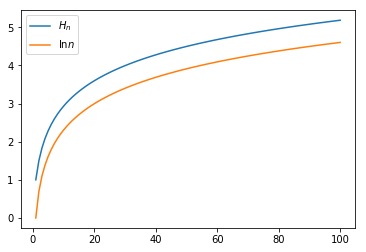

In [6]:
H=np.zeros(100)
n=range(1,101)
H[0]=1;
for k in range(1,100):
    H[k]=H[k-1]+1/(k+1)
plt.plot(n,H,label='$H_n$')
plt.plot(n,log(n), label='$\ln{n}$')
leg=plt.legend(loc='best')

Por lo tanto, el costo esperado de búsqueda (exitosa o infructuosa) en un ABB es aproximadamente $2H_n \approx 2\ln{n} \approx 1.386 \log_2{n}$, lo cual es solo $38.6$ por cierto peor que un árbol óptimo, cuyo costo de búsqueda es $\log_2{n}$.

Se puede demostrar que la varianza también es logarítmica, por lo que en la práctica el tiempo de búsqueda debería ser cercano al promedio.

Sin embargo, este análisis supone que las inserciones llegan en orden aleatorio, lo cual no necesariamente se cumple en la vida real. 

### Eliminación en un ABB

La eliminación de una llave $x$ es sencilla de efectuar en algunos casos, pero el caso complicado es cuando la llave tiene dos hijos:

#### Eliminación de una llave sin hijos

En este caso, el nodo interno que contiene a $x$ desaparece y en su lugar queda un nodo externo:

![eliminacionABB1](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/eliminacionABB1.gif?raw=1)

#### Eliminación de una llave con 1 hijo

En este caso, el padre de la llave $x$ pasa a apuntar al único hijo de $x$:

![eliminacionABB2](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/eliminacionABB2.gif?raw=1)

#### Eliminación de una llave con 2 hijos

Si $x$ tiene 2 hijos, no podemos eliminarla directamente, pero sí podemos eliminar a la que la sigue en orden ascendente, digamos $y$. Se puede demostrar que $y$ necesariamente es unos de los dos casos anteriores, de modo que es fácil de eliminar. Luego de concluído ese proceso, escribimos $y$ en lugar de $x$ en el campo `info` del nodo respectivo.

![eliminacionABB3](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/eliminacionABB3.gif?raw=1)

Por simetría, esto mismo podría haberse hecho con la llave que sigue a $x$ en orden descendente.

El análisis del costo esperado de búqueda que hicimos anteriormente es válido si solo hay inserciones. El análisis en el caso en que se incluyen eliminaciones es un un problema matemáticamente muy complicado, y sigue siendo un problema abierto. La evidencia experimental indica que se obtienen mejores resultados si se alterna o si se aleatoriza al elegir entre sucesor o el predecesor de $x$ en caso que haya que elegir.

### Implementación recursiva de la eliminación

Por simplicidad, omitimos el código para la inserción y búsqueda, y en el caso de un nodo con 2 hijos, eliminamos siempre el sucesor. También ignoramos las eliminaciones de llaves que no están en el árbol.

In [10]:
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
    
    def deletemin(self): # Elimina llave mínima del árbol, retorna (llave_min,raiz_arbol_restante)
        if isinstance(self.izq,Nodoe): # No hay hijo izquierdo
            return (self.info,self.der)
        # hay hijo izquierdo
        (llave_min,izq_sin_min)=self.izq.deletemin()
        return (llave_min,Nodoi(izq_sin_min,self.info,self.der))
        
    def delete(self,x):
        if x<self.info:
            return Nodoi(self.izq.delete(x),self.info,self.der)
        if x>self.info:
            return Nodoi(self.izq,self.info,self.der.delete(x))
        # x==self.info
        if isinstance(self.izq,Nodoe): # No hay hijo izquierdo
            return self.der
        if isinstance(self.der,Nodoe): # No hay hijo derecho
            return self. izq
        # Hay hijo izquierdo y derecho
        (y,der_sin_min)=self.der.deletemin()
        return(Nodoi(self.izq,y,der_sin_min))
        
    def __str__(self):
        return "("+self.izq.__str__()+str(self.info)+self.der.__str__()+")"

class Nodoe:
    def __init__(self):
        pass
    
    def delete(self,x):
        return self
    
    def __str__(self):
        return"☐"

class Arbol:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz     
        
    def delete(self,x):
        self.raiz=self.raiz.delete(x)
    
    def __str__(self):        
        return self.raiz.__str__()

Para probar este algoritmo utilizaremos el árbol que vimos en el capítulo 4:

![ejemplo-ABB](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/ejemplo-ABB.png?raw=1)

In [11]:
a=Arbol(
    Nodoi(
        Nodoi(
            Nodoi(Nodoe(),15,Nodoe()),
            20,
            Nodoi(
                Nodoi(Nodoe(),30,Nodoe()),
                35,
                Nodoe()
            )
        ),
        42,
        Nodoi(
            Nodoi(
                Nodoi(
                    Nodoi(Nodoe(),65,Nodoe()),
                    72,
                    Nodoi(Nodoe(),81,Nodoe())
                ),
                90,
                Nodoe()
            ),
            95,
            Nodoe()
        )
       )
)

In [12]:
print(a)

(((☐15☐)20((☐30☐)35☐))42((((☐65☐)72(☐81☐))90☐)95☐))


In [13]:
a.delete(30)
print(a)

(((☐15☐)20(☐35☐))42((((☐65☐)72(☐81☐))90☐)95☐))


In [14]:
a.delete(95)
print(a)

(((☐15☐)20(☐35☐))42(((☐65☐)72(☐81☐))90☐))


In [15]:
a.delete(42)
print(a)

(((☐15☐)20(☐35☐))65((☐72(☐81☐))90☐))


In [16]:
a.delete(44) # 44 no está en el árbol
print(a)

(((☐15☐)20(☐35☐))65((☐72(☐81☐))90☐))


In [17]:
a.delete(20)
print(a)

(((☐15☐)35☐)65((☐72(☐81☐))90☐))


### Implementación no recursiva de la eliminación

Al programar la eliminación de esta manera, necesitamos modificar el nodo padre de $x$. Para simplificar, asegurando que todo nodo tenga un padre, incluso la raíz, durante el proceso de eliminación simularemos que la raíz es hija derecha de un nodo con llave "$-\infty$".

In [18]:
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
    
    def __str__(self):
        return "("+self.izq.__str__()+str(self.info)+self.der.__str__()+")"

class Nodoe:
    def __init__(self):
        pass
    
    def __str__(self):
        return"☐"

import math
class Arbol:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz     
        
    def delete(self,x):
        cabecera=Nodoi(None,-math.inf,self.raiz)
        p=cabecera # padre del candidato a ser eliminado
        q=cabecera.der # el candidato
        while not isinstance(q,Nodoe):
            if x<q.info:
                (p,q)=(q,q.izq)
            elif x>q.info:
                (p,q)=(q,q.der)
            else: # encontramos x
                if isinstance(q.izq,Nodoe): # no hay hijo izquierdo
                    r=q.der
                elif isinstance(q.der,Nodoe): # no hay hijo derecho
                    r=q.izq
                else: # hay 2 hijos, eliminamos el mínimo del árbol derecho y lo movemos a q
                    s=q.der
                    if isinstance(s.izq,Nodoe): # encontramos el mín de inmediato
                        q.info=s.info
                        q.der=s.der
                    else: # el mín está más abajo
                        t=s.izq # s es el padre del candidato a min, t es el candidato
                        while not isinstance(t.izq,Nodoe): # mientras no encontremos el final de la rama izquierda
                            (s,t)=(t,t.izq)
                        q.info=t.info
                        s.izq=t.der
                    r=q
                if x<p.info:
                    p.izq=r
                else:
                    p.der=r
                self.raiz=cabecera.der
                return        
        # si llegamos acá, x no estaba, no hacemos nada
    
    def __str__(self):        
        return self.raiz.__str__()

In [19]:
a=Arbol(
    Nodoi(
        Nodoi(
            Nodoi(Nodoe(),15,Nodoe()),
            20,
            Nodoi(
                Nodoi(Nodoe(),30,Nodoe()),
                35,
                Nodoe()
            )
        ),
        42,
        Nodoi(
            Nodoi(
                Nodoi(
                    Nodoi(Nodoe(),65,Nodoe()),
                    72,
                    Nodoi(Nodoe(),81,Nodoe())
                ),
                90,
                Nodoe()
            ),
            95,
            Nodoe()
        )
       )
)

In [20]:
print(a)

(((☐15☐)20((☐30☐)35☐))42((((☐65☐)72(☐81☐))90☐)95☐))


In [21]:
a.delete(30)
print(a)

(((☐15☐)20(☐35☐))42((((☐65☐)72(☐81☐))90☐)95☐))


In [22]:
a.delete(95)
print(a)

(((☐15☐)20(☐35☐))42(((☐65☐)72(☐81☐))90☐))


In [23]:
a.delete(42)
print(a)

(((☐15☐)20(☐35☐))65((☐72(☐81☐))90☐))


In [24]:
a.delete(44) # 44 no está en el árbol
print(a)

(((☐15☐)20(☐35☐))65((☐72(☐81☐))90☐))


In [25]:
a.delete(20)
print(a)

(((☐15☐)35☐)65((☐72(☐81☐))90☐))


## Rotaciones en un ABB

Una operación que es la base de muchos algoritmos es la *rotación* (o rotación simple, para diferenciarla de la rotación doble, que veremos más adelante).

Una rotación entre los nodos $b$ y $d$ es la siguiente transformación:

![rotacion-simple](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/rotacion-simple.png?raw=1)

Como lo sugiere la figura, por simetría esta operación también se puede hacer en la dirección inversa.

Esta operación tiene costo constante, porque solo requiere modificar tres punteros, y preserva el orden de izquierda a derecha que caracteriza a un ABB. Su efecto es que $A$ y $b$ suben un nivel, mientras que $d$ y $E$ bajan un nivel.

### Aplicación: Inserción en la raíz

El método estándar de inserción en un ABB es inserción en las hojas.
Veremos a continuación que existe un método alternativo, que deja al nuevo elemento como raíz del árbol.

El método consiste en insertar el nuevo elemento de la manera usual, y luego hacer una secuencia de rotaciones que vayan haciéndolo ascender, hasta que llegue a estar en la raíz.

In [26]:
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
    def right_rotation(self):
        return(Nodoi(self.izq.izq,
                     self.izq.info,
                     Nodoi(self.izq.der,self.info,self.der)))   
    def left_rotation(self):
        return(Nodoi(Nodoi(self.izq,self.info,self.der.izq),
                     self.der.info,
                     self.der.der))
    def root_insert(self,x):
        assert x!=self.info
        if x<self.info:
            self.izq=self.izq.root_insert(x) # x queda como raíz del hijo izquierdo
            return self.right_rotation() # la rotación deja a x como raíz
        else:
            self.der=self.der.root_insert(x) # x queda como raíz del hijo derecho
            return self.left_rotation() # la rotación deja a x como raíz
        
    def __str__(self):
        return "("+self.izq.__str__()+str(self.info)+self.der.__str__()+")"

class Nodoe:
    def __init__(self):
        pass
    
    def root_insert(self,x):
        return Nodoi(Nodoe(),x,Nodoe())
    
    def __str__(self):
        return"☐"

class Arbol:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz     
        
    def root_insert(self,x):
        self.raiz=self.raiz.root_insert(x)
    
    def __str__(self):        
        return self.raiz.__str__()

In [27]:
a=Arbol()
a.root_insert(10)
print(a)
a.root_insert(20)
print(a)
a.root_insert(30)
print(a)
a.root_insert(25)
print(a)
a.root_insert(15)
print(a)

(☐10☐)
((☐10☐)20☐)
(((☐10☐)20☐)30☐)
(((☐10☐)20☐)25(☐30☐))
((☐10☐)15((☐20☐)25(☐30☐)))


### Aplicación: Árboles cartesianos y "Treaps"

Un *árbol cartesiano* es un árbol binario en que cada nodo interno contiene un par ordenado $(x,y)$, tal que:

* Si se consideran las coordenadas $x$, el árbol es un ABB
* Si se consideran las coordenadas $y$, el árbol es un árbol de prioridad

La siguiente figura muestra a un árbol cartesiano en que la máxima prioridad corresponde al valor mínimo de $y$:

![cartesian-tree](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/cartesian-tree.png?raw=1)

Intuitivamente, podemos imaginar que la prioridad $y$ corresponde a la hora en que la llave $x$ ingresó al árbol. Esto explica que la raíz tenga el valor mínimo de $y$, y que estos valores vayan creciendo a medida que descendemos en el árbol.

Sin embargo, _no estamos obligados a insertar las llaves en orden cronológico_. En efecto, veremos que un nuevo par $(x,y)$ se puede insertar en cualquier momento, aunque su $y$ no sea mayor que los de los nodos que ya están en el árbol..

Para insertar un nuevo par ordenado en un árbol cartesiano, primero efectuamos una inserción como si fuera un ABB, con lo cual el nuevo nodo cumple con las restricciones "izquierda-derecha" en su coordenada $x$, pero posiblemente no con las restricciones de prioridad "arriba-abajo" de la coordenada $y$. Para corregir esto último, a continuación, hacemos una serie de rotaciones hasta conseguir que el nuevo nodo cumpla con las restricciones de prioridad.

También es posible eliminar un nodo dado de un árbol cartesiano. Como al eliminar un nodo sus dos árboles hijos quedan "huérfanos", es necesario fusionarlos en uno solo. Para esto, elegimos a la raíz de mejor prioridad para que quede como raíz del árbol resultante. De los tres subárboles restantes, uno va a un lado de la nueva raíz, y los otros dos deben fusionarse recursivamente.

Una vez que tenemos una implementación de árboles cartesianos, podemos utilizarla para obtener un nuevo tipo de diccionario, llamado un *Treap* (mezcla de "tree" y de "heap"), que posee las mismas características de desempeño promedio que un ABB, pero que es inmune a que las llaves lleguen ordenadas, o a que un adversario le entregue la secuencia de inserciones en un orden malicioso. Para esto, dado una nueva llave $x$ para insertar, generamos una prioridad $y$ *al azar*, e insertamos el par $(x,y)$ resultante. El efecto neto es equivalente a si las llaves hubieran llegado en un orden aleatorio.

## Árboles AVL

Veremos a continuación que es posible implementar diccionarios en que los costos de búsqueda, inserción y eliminación son garantizadamente $O(\log{n})$ *en el peor caso*.

Hay muchas maneras de conseguir esto a través de modificaciones del algoritmo básico de los ABBs, y hablamos en general de *árboles balanceados* para referirnos a este tipo de diccionarios.

Comenzaremos viendo el más antiguo de estos algoritmos, inventado por Adelson-Velskii y Landis y conocido por sus iniciales como *árboles AVL*.

Si queremos garantizar un costo de búsqueda logarítmico, lo ideal sería poder construir árboles perfectamente balanceados, en que siempre los elementos se repartieran en partes iguales a ambos lados de la raíz, y en que por lo tanto las alturas a ambos lados también fueran idénticas.
Pero eso no es posible por varias razones.
Por una parte, porque el costo de insertar un nuevo elemento en ese tipo de árbol sería muy grande en el peor caso, pero también porque a medida que bajamos en en árbol, a menos que el número de llaves sea exactamente uno menos que una potencia de $2$, necesariamente terminaremos encontrando subárboles de tamaño $2$, en los cuales a un lado hay un árbol de altura $1$, y al otro lado un árbol de altura $0$.

Por lo tanto, es necesario relajar un poco la exigencia, para acomodar a ese tipo de subárboles.

Los árboles AVL se definen como ABBs en que todos sus nodos internos cumplen además una condición de *altura balanceada*, que consiste en que sus subárboles hijos pueden tener alturas diferentes, pero la diferencia de sus alturas no puede ser mayor que 1.

![condicion-AVL](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/condicion-AVL.png?raw=1)

Más precisamente, si la función $h(T)$ es la altura del árbol $T$, para cada nodo interno sus subárboles hijos, digamos $A$ y $B$, deben cumplir que $|h(A)-h(B)|\le 1$.

El siguiente ejemplo muestra un árbol en que en cada nodo (interno o externo) se ha anotado la altura del subárbol que lo tiene como raíz.
Este árbol cumple la condición AVL en todos sus nodos, excepto en el que aparece marcado con asterisco, cuyos hijos tienen diferencia de altura 2, y por lo tanto el árbol no es AVL.

![ejemplo-no-AVL](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/ejemplo-no-AVL.png?raw=1)

En cambio, este otro árbol, muy similar, sí cumple la condición en todos sus nodos, y es por lo tanto un árbol AVL.

![ejemplo-AVL](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/ejemplo-AVL.png?raw=1)

### Chequeando si un árbol es AVL

Para determinar si un árbol es AVL, debemos calcular la altura de cada subárbol y comparar las alturas de todos los subárboles "hermanos" para ver si su diferencia excede o no 1. La siguiente implementación lo hace, pero veremos que de una manera ineficiente:

In [13]:
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
    
    def altura(self):
        return 1+max(self.izq.altura(),self.der.altura())
    
    def es_AVL(self):
        return abs(self.izq.altura()-self.der.altura())<=1 \
                and self.izq.es_AVL() and self.der.es_AVL()
        
    def __str__(self):
        return "("+self.izq.__str__()+str(self.info)+self.der.__str__()+")"

class Nodoe:
    def __init__(self):
        pass

    def altura(self):
        return 0
    
    def es_AVL(self):
        return True
    
    def __str__(self):
        return"☐"

class Arbol:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz     
    
    def es_AVL(self):
        return self.raiz.es_AVL()
    
    def __str__(self):        
        return self.raiz.__str__()

In [14]:
a1=Arbol(Nodoi(Nodoi(Nodoe(),1,Nodoe()),
            2,
            Nodoi(Nodoe(),3,Nodoi(Nodoe(),4,Nodoe()))))
print(a1)
print(a1.es_AVL())

((☐1☐)2(☐3(☐4☐)))
True


In [15]:
a2=Arbol(Nodoi(Nodoi(Nodoe(),1,Nodoe()),
            2,
            Nodoi(Nodoe(),3,Nodoi(Nodoe(),4,Nodoi(Nodoe(),5,Nodoe())))))
print(a2)
print(a2.es_AVL())

((☐1☐)2(☐3(☐4(☐5☐))))
False


Lo anterior funciona, pero puede ser ineficiente. Por ejemplo, si el árbol fuera perfectamente balanceado, tendríamos que el costo de calcular la altura de un árbol de tamaño $n$ sería

$$
h(n)=1+2h\left(\frac{n}{2}\right)
$$

que tiene solución $h(n)=\Theta(n)$, lo cual es razonable, porque para calcular la altura se requiere recorrer todo el árbol. Pero determinar si el árbol es AVL demora un tiempo $a(n)$, donde

$$
a(n)= 2a\left(\frac{n}{2}\right) + 2h\left(\frac{n}{2}\right)
$$

y esto tiene solución $a(n)=\Theta(n\log{n})$ por el Teorema Maestro.

Veremos a continuación que esto se puede hacer más eficientemente, en tiempo lineal.

---

### Ejercicio 6.1 (Chequear si un árbol es AVL en tiempo lineal)

En este ejercicio usted debe modificar la implementación anterior para asegurar que cada nodo del árbol se visite solo una vez, asegurando de esta manera que el costo de determinar si un árbol es AVL sea $\Theta(n)$.

Para esto, usted debe fusionar las funciones ``altura`` y ``es_AVL``en una sola función ``altura_AVL``, que retorne una tupla $(h,a)$, donde $h$ es la altura y $a$ es un booleano que dice si el árbol es AVL. De esta manera, al invocar la función se tiene de una sola vez toda la información necesaria.

In [16]:
# Escriba aquí la nueva definición de nodos y árbol
# Los nodos deben implementar la función altura_AVL
# pero la clase Arbol debe seguir implemmentando una función es_AVL

A continuación, pruébela con los dos árboles utilizados anteriormente:

In [ ]:
a1=Arbol(Nodoi(Nodoi(Nodoe(),1,Nodoe()),
            2,
            Nodoi(Nodoe(),3,Nodoi(Nodoe(),4,Nodoe()))))
print(a1)
print(a1.es_AVL())

In [ ]:
a2=Arbol(Nodoi(Nodoi(Nodoe(),1,Nodoe()),
            2,
            Nodoi(Nodoe(),3,Nodoi(Nodoe(),4,Nodoi(Nodoe(),5,Nodoe())))))
print(a2)
print(a2.es_AVL())

---

### Altura mínima y máxima de un árbol AVL

Consideremos un árbol AVL con $n$ llaves y altura $h$.
Sabemos que su número de hojas es $n+1$, y también sabemos que el número de hojas es menor o igual a $2^h$.
Por lo tanto, $h \ge \lceil\log_2{(n+1)}\rceil$.

Para encontrar una cota superior, consideremos la familia $A_h$ de los árboles AVL de altura $h$ con el mínimo número de hojas. Si $h=0$, el único árbol posible es el árbol vacío (solo una hoja) y es AVL.
Si $h=1$, el único árbol posible es el que tiene un nodo interno y dos hojas como hijos, y también es AVL.

Consideremos el caso $h\ge 2$. El árbol $A_h$ debe tener una raíz y dos subárboles hijos. Si queremos economizar al máximo el número de hojas, uno de ellos debe tener altura $h-1$, para que la altura del árbol completo sea $h$, y el otro debe tener altura $h-2$, para que se cumpla la condición AVL, y ambos deben tener el mínimo posible de hojas, es decir, deben pertenecer a la misma familia.

Por lo tanto, la familia $A_h$ se puede construir recursivamente de la siguiente manera:

![arboles-fibonacci](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/arboles-fibonacci.png?raw=1)

Los árboles así construídos se llaman *árboles de Fibonacci*.

Si llamamos $N_h$ al número de hojas del árbol $A_h$, tenemos que

$$
\begin{align}
N_0 &= 1\\
N_1 &= 2\\
N_h &= N_{h-1} + N_{h-2}
\end{align}
$$

Esta es la misma ecuación de Fibonacci, comenzando dos pasos más adelante. Por lo tanto, si denotamos $f_n$ al $n$-ésimo número de Fibonacci, tenemos que $N_h=f_{h+2}=\Theta(\phi^h)$.

Como los árboles de Fibonacci son los árboles AVL con el mínimo de hojas, cualquier otro árbol AVL tendrá más hojas que ellos, y por lo tanto, tomando logaritmos, la altura de todo árbol AVL será $O(\log_{\phi}{(n+1)})$.

### Operaciones sobre un árbol AVL

#### Búsqueda

Un árbol AVL es un ABB (con una condición adicional de balance), así que el algoritmo de búsqueda es el mismo.
El que la altura de todo árbol AVL sea logarítmica garantiza que las operaciones de búsqueda tomarán tiempo logarítmico en el peor caso.

#### Inserción

Veremos a continuación que se puede insertar una nueva llave en un árbol AVL, preservando la condición AVL, en tiempo a lo más proporcional a la altura del árbol.

Supongamos que se inserta una nueva llave $x$ en un árbol AVL como el que muestra la siguiente figura:

![AVL1](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/AVL1.png?raw=1)

Supongamos que se inserta la llave $x$, siguiendo una trayectoria desde la raíz hasta la hoja respectiva, y que luego se retorna hacia arriba revisando en cada nodo de esa trayectoria si la condición AVL se sigue cumpliendo. Si en todos ellos la condición se cumple, no es necesario hacer nada más. Si no, supongamos qie el nodo marcado con asterisco ($d$) es el primero (de abajo hacia arriba) en donde la condición no se cumple.

Consideremos primero el caso en que a partir de $d$, los dos pasos siguientes hacia abajo fueron en la misma dirección (ambos hacia la izquierda, en la figura). Esto se llama una *inserción exterior*, y los dos pasos son de tipo "zig-zig" (o "zag-zag", en el caso simétrico en que los dos pasos fueron hacia la derecha).

Para que la condición AVL no se cumpla en $d$ y sí se cumpla en $b$, es necesario que los tres subárboles $A$, $C$ y $E$ sean todos de la misma altura, digamos $h$, y que la inserción de $x$ haga que la altura de $A$ crezca a $h+1$. Nótese que la altura del árbol, antes de la inserción, era $h+2$.

En este caso hacemos una rotación (simple) entre los nodos $b$y $d$, con el resultado que se muestra a la derecha. En el árbol resultante, los nodos $b$ y $d$ ahora cumplen la condición AVL (con diferencia cero) y, más aún, después de esta rotación, el árbol resultante tiene altura $h+2$. Por lo tanto, el árbol completo no ha cambiado de altura, lo cual implica que ningún nodo más arriba puede estar desbalanceado.

Por lo tanto, en el caso de una inserción exterior, basta con a lo más una rotación para restaurar la condición AVL en todo el árbol.

Consideremos ahora el caso de una *inserción interior*, en que los dos primeros pasos fueron en direcciones opuestas ("zig-zag" o el simétrico "zag-zig"):

![AVL2](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/AVL2.png?raw=1)

En este caso, es necesario entrar a examinar la estructura interna del subárbol $C$:

![AVL3](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/AVL3.png?raw=1)

En este caso, $x$ puede ir al subárbol $F$ o al subárbol $G$ indistintamente (¡pero no a ambos!).
Para restaurar la condición de balance AVL, necesitamos hacer _dos_ rotaciones: primero entre $c$ y $b$, y luego entre $c$ y $d$. El resultado neto es que el zig-zag $d-b-c$ se transforma en el subárbol perfectamente balanceado $b-c-d$.
El efecto combinado de estas dos rotaciones se llama una _rotación doble_.

Tal como ocurrió en el caso anterior, los tres nodos involucrados quedan cumpliendo la condición AVL, y el árbol resultante tiene altura $h+2$, la misma que tenía antes de la inserción. Por lo tanto, no puede haber nodos desbalanceados más arriba.

Esto, sumado a lo que vimos antes, demuestra que **a lo más una rotación (simple o doble) basta para recuperar el balance AVL después de una inserción**.

In [28]:
class Nodoi:
    def __init__(self, izq, info, der):
        self.izq=izq
        self.info=info
        self.der=der
        self.height=1+max(izq.height,der.height)

    def right_rotation(self):
        return(Nodoi(self.izq.izq,
                     self.izq.info,
                     Nodoi(self.izq.der,self.info,self.der)))
    
    def left_rotation(self):
        return(Nodoi(Nodoi(self.izq,self.info,self.der.izq),
                     self.der.info,
                     self.der.der))
        
    def insert(self,x):
        assert x!=self.info
        if x<self.info:
            p=Nodoi(self.izq.insert(x),self.info,self.der)
            if p.izq.height>p.der.height+1:
                if x<p.izq.info: # inserción exterior
                    p=p.right_rotation()
                else: # inserción interior
                    p=Nodoi(p.izq.left_rotation(),p.info,p.der).right_rotation()           
        else: # x>self.info, simétrico del anterior
            p=Nodoi(self.izq,self.info,self.der.insert(x))
            if p.der.height>p.izq.height+1:
                if x>p.der.info: # inserción exterior
                    p=p.left_rotation()
                else: # inserción interior
                    p=Nodoi(p.izq,p.info,p.der.right_rotation()).left_rotation()         
        return p
        
    def __str__(self):
        return "("+self.izq.__str__()+str(self.info)+self.der.__str__()+")"

class Nodoe:
    def __init__(self):
        self.height=0
    
    def insert(self,x):
        return Nodoi(Nodoe(),x,Nodoe())
    
    def __str__(self):
        return"☐"

class ArbolAVL:
    def __init__(self,raiz=Nodoe()):
        self.raiz=raiz     
        
    def insert(self,x):
        self.raiz=self.raiz.insert(x)
    
    def __str__(self):        
        return self.raiz.__str__()

In [29]:
a=ArbolAVL()
a.insert(20)
print(a)
a.insert(40)
print(a)
a.insert(80)
print(a)
a.insert(10)
print(a)
a.insert(15)
print(a)

(☐20☐)
(☐20(☐40☐))
((☐20☐)40(☐80☐))
(((☐10☐)20☐)40(☐80☐))
(((☐10☐)15(☐20☐))40(☐80☐))


#### Eliminación

La eliminación en árbol AVL se realiza de manera análoga a un ABB, pero también es necesario verificar que la condición de balance se mantenga una vez eliminado el elemento. En caso que dicha condición se pierda, será necesario realizar una rotación simple o doble dependiendo del caso, pero es posible que se requiera más de una rotación para reestablecer el balance del árbol.

## Árboles 2-3

Los árboles 2-3 son árboles cuyos nodos internos pueden ser _binarios_ o _ternarios_. Los nodos binarios tienen una llave en su interior, y los nodos ternarios tienen dos llaves.

Las llaves contenidas en los nodos del árbol cumplen la siguiente relación de orden de izquierda a derecha:

![orden-2-3](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/orden-2-3.png?raw=1)

En un nodo binario, la llave $X$ actúa como separador entre las llaves del subárbol izquierdo y las del derecho.
En un nodo ternario, la llave $X$ separa el subárbol izquierdo del subárbol del medio, y la llave $Y$ separa el subárbol del medio del subárbol derecho.

Gracias a este orden, se puede realizar una búsqueda utilizando una generalización del algoritmo de búsqueda en un ABB.

Además de lo anterior, un árbol 2-3 debe tener a todas sus hojas en el mismo nivel. El siguiente es un ejemplo de un árbol 2-3 que satisface ambas condiciones:

![ejemplo-2-3](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/ejemplo-2-3.png?raw=1)

Nótese que si un árbol 2-3 tiene $n$ llaves, ya no necesariamente se cumple que el número de hojas (nodos externos) sea uno más que el número de nodos internos, pero sí se cumple que el número de hojas es igual a $n+1$.

Dado que la altura de un árbol 2-3 es mínima si todos sus nodos son ternarios y es máxima si todos sus nodos son binarios, es fácil ver que

$$
\log_3{(n+1)} \le \text{ altura } \le \log_2{(n+1)}
$$

y por lo tanto el costo de búsqueda es logarítmico en el peor caso.

### Inserción en un árbol 2-3

Para insertar una nueva llave $X$ en un árbol 2-3, se realiza una búsqueda infructuosa y se inserta dicha llave en el último nodo interno visitado durante la búsqueda. Esto puede conducir a dos casos distintos:

* Si el nodo tenía solo una llave (era binario), ahora queda con dos llaves y pasa a ser ternario:

![insercion-2-3-binario](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/insercion-2-3-binario.png?raw=1)

* Si el nodo tenía 2 llaves (era ternario), queda transitoriamente con 3 llaves y 4 hijos. Se dice que ese nodo está saturado, o que tiene *overflow*, y esto se corrige dividiendo el nodo en dos nodos binarios (*split*). Los 4 hijos se reparten entre esos dos nodos. Respecto a las llaves, la menor queda en el nodo izquierdo, la mayor en el nodo derecho, y la mediana sube y se inserta en el padre, para actuar como separador entre los dos subárboles resultantes del *split*.

![insercion-2-3-ternario](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/insercion-2-3-ternario.png?raw=1)

Si el padre era binario, la llegada de una nueva llave lo transforma en ternario y el proceso concluye ahí. Pero si ya era ternario, el padre ahora está saturado y el proceso se repite.

En el peor caso, es posible que la raíz llegue a dividirse. En ese caso, se crea una nueva raíz un nivel más arriba la altura del árbol crece en 1.

#### Ejemplo de inserciones en un árbol 2-3

![inserciones-2-3](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/inserciones-2-3.png?raw=1)

---

### Ejercicio 6.2 (Número de operaciones *split*)

Supongamos que comenzamos con un árbol 2-3 vacío y a continuación insertamos $n$ llaves. El objetivo de este ejercicio es calcular cuántas operaciones *split* se pueden llegar a ejecutar a lo largo de este proceso, en el peor caso.

Una manera de acotar este número de operaciones es ver que una inserción puede gatillar la ejecución de $O(\log{n})$ operaciones *split*, y como son $n$ inserciones, el número total de operaciones *split* es $O(n\log{n})$.

Lo anterior es una cota superior, pero en realidad está muy sobredimensionada.

Demuestre que el número total de operaciones *split* ejecutadas al insertar $n$ llaves comenzando con un árbol 2-3 vacío es $O(n)$ en el peor caso. Escriba su demostración en el siguiente recuadro.

*Indicación*: Considere el impacto de un *split* sobre el número de nodos del árbol.

#### Demostración:



---

### Eliminación en un árbol 2-3

Supongamos que queremos eliminar una llave $Z$. Sin perder generalidad, podemos suponer que $Z$ está en el nivel más bajo de árbol. Si esto no es así, entonces el sucesor y el predecesor de $Z$ se encuentran necesariamente en el nivel inferior, en cuyo caso basta con eliminar uno de ellos, y luego sobreescribir esa llave en el lugar de $Z$.

La eliminación presenta dos posibles casos:

* El nodo en donde se encuentra $Z$ es ternario. En este caso, se elimina $Z$ junto con una hoja y el nodo queda como binario.
![eliminacion2-3a](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/eliminacion2-3a.gif?raw=1)

* El nodo en donde se encuentra $Z$ es binario. En ese caso, al eliminar $Z$ y una hoja, el nodo queda como "unario" y sin llaves (*underflow*). Cuando esto sucede, tenemos dos casos:

    * Si el nodo hermano es ternario, le quitamos una llave y una hoja y ambos quedan como binarios. Nótese que, para preservar el orden, se debe realizar un traspaso con la llave en el padre que separa a ambos nodos:
    ![eliminacion2-3b](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/eliminacion2-3b.gif?raw=1)
    
    * Si el nodo hermano es binario, no le podemos quitar nada. En ese caso, fusionamos a ambos hermanos, resultando un nodo ternario, y la llave del padre que actuaba como separador baja a este nuevo nodo:
    ![eliminacion2-3c](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/eliminacion2-3c.gif?raw=1)
    
    Cuando ocurre esto último, el padre pierde un hijo y una llave, lo cual podría dejarlo transformado en unario. En ese caso, se repite el procedimiento anterior, un nivel más arriba.
    
El peor caso es que finalmente la raíz quede como un nodo vacío unario. En ese caso, se elimina esa raíz y su hijo queda como raíz.

### Costo de las operaciones

Dado que el árbol 2-3 tiene altura logarítmica, y que las operaciones de inserción, eliminación y búsqueda hacen una cantidad de trabajo constante en cada nivel, el costo de dichas operaciones en el peor caso es $\Theta(\log{n})$.

## Árboles B (*B-trees*)

Los árboles 2-3 se pueden generalizar a árboles con un mayor número de hijos.
La idea es que cuando un nodo excede el número máximo de hijos (y de llaves) permitidos, se divide en dos (*split*), con la mitad de los hijos cada uno.

Más precisamente, supongamos que $t\ge 2$ es un parámetro fijo, y permitimos que todo nodo tenga un mínimo de $t$ y un máximo de $2t-1$ hijos. Un nodo con $k$ hijos tiene $k-1$ llaves, que actúan como separadoras entre sus hijos.

Los árboles 2-3 son árboles B con $t=2$. En la práctica, los árboles $B$ se implementan con valores mucho más grandes de $t$, por ejemplo $t=100$.

La motivación para utilizar valores altos de $t$ es hacer coincidir el tamaño del nodo con la capacidad de un bloque de disco (memoria secundaria). Ésta es memoria masiva de acceso más lento que la memoria cental del computador (memoria RAM), y al tener un grado alto de ramificación, el árbol tiene muy pocos niveles. Gracias a esto, el número de accesos a disco para implementar las operaciones es también muy pequeño.

### Inserción en un árbol B

* La nueva llave, junto con una nueva hoja, se agregan en el nodo correspondiente en el nivel inferior del árbol.

* Si ese nodo queda saturado (*overflow*), es decir, si queda con $2t$ hijos y $2t-1$ llaves, se divide en dos nodos con $t$ hijos y $t-1$ llaves cada uno. La llave sobrante, que debe ser la mediana del conjunto de llaves, sube al padre como separador de estos dos nuevos nodos.

* Si a causa de esto el padre queda saturado, se repite el procedimiento un nivel más arriba.

* El peor caso es que la raíz llegue a estar saturada. En ese caso, la raíz se divide en dos nodos y se crea un nuevo nodo binario como padre de ellos. Este nodo es la nueva raíz.

Nótese que, debido a lo anterior, la raíz es el único nodo que está exento de la obligación de tener al menos $t$ hijos.

### Eliminación en un árbol B

* Tal como hicimos en el caso de los árboles 2-3, sin perder generalidad, suponemos que la llave a eliminar está en el nivel inferior. Se elimina la llave y una hoja.

* Si a causa de esto el nodo queda con menos de $t$ hijos, tenemos dos casos:
    * Si el hermano tiene más de $t$ hijos, redistribuimos los hijos y las llaves entre ambos hermanos, mitad y mitad.
    * Si el hermano tiene solo $t$ hijos, no le podemos quitar nada. En ese caso, fusionamos ambos nodos, y la llave del padre que los separaba baja al nuevo nodo. Si a causa de eso el padre queda con menos del mínimo de hijos, se repite este procedimiento un nivel más arriba.
    * Excepcionalmente, a la raíz se le permite que tenga menos de $t$ hijos, pero si llega a quedar como un nodo unario (sin llaves), se elimina y su hijo queda como nueva raíz.
    

### Costo de las operaciones en un árbol B

En las estructuras de datos implementadas en memoria secundacia, el costo de las operaciones se aproxima por el número de bloques leídos o escritos, y se ignora el costo del procesamiento en memoria RAM. Esta aproximación se justifica porque el acceso a memoria secundaria es mucho más lento que a memoria RAM.

En un árbol B, el número de accesos a bloques corresponde al número de niveles del árbol, el cual es logarítmico, pero ese logaritmo es en una base muy grande (entre $t$ y $2t-1$), de modo que en la práctica podemos decir que el costo es "casi constante".

### Variantes de los árboles B

Veremos dos variantes de la definición anterior, que son importantes en la práctica.

#### Árboles B*

La idea es no hacer un _split_ apenas un nodo se satura, sino ver si el hermano tiene capacidad como para recibir que le enviemos llaves e hijos. El _split_ solo se hace cuando _ambos_ nodos están saturados, y en ese caso se crea un tercer nodo para distribuir entre los tres equitativamente el contenido.

En los árboles B, la utilización del espacio (fracción ocupada de un nodo) varía entre 50% y 100%. En un árbol B* la utilización varía entre 66,6% y 100%. Al haber una mayor utilización, el grado de ramificación de los nodos es mayor, y por la altura del árbol es menor.

#### Árboles B+

En los árboles B+, los datos del conjunto se almacenan en orden ascendente de llave en las hojas. Cada hoja tiene una cierta capacidad máxima (correspondiente a la capacidad del bloque de disco en donde se almacena), y cuando se excede, la hoja se divide en dos, cada una 50% llena. Adicionalmente, las hojas se enlazan en una lista de doble enlace, que permite un recorrido secuencial de los datos en orden ascendente o descendente de llave.

La máxima llave de cada hoja (excepto la de la hoja de más a la derecha) se toma como separador y se almacena dentro de los nodos internos del árbol. Nótese que en los nodos internos solo están las llaves y no toda la información que puede acompañarlas, en cambio en las hojas está la información completa.

Debido a esto, al hacer una búsqueda, las preguntas se hacen con $\le/>$ y se debe llegar siempre hasta el nivel de las hojas.

El nivel de las hojas se llama en "*B-file*", y el conjunto de los nodos internos del árbol se llama el "*B-index*".

Los árboles B+ son la versión más utilizada, porque permiten hacer tanto recorridos secuenciales como búsqueda eficientes en memoria secundaria.

## Árboles Digitales

En esta sección exploramos una manera distinta de almacenar un diccionario usando árboles.
Hasta ahora hemos supuesto que las llaves pertenecen a algún conjunto ordenado, pero no hemos hecho ninguna suposición respecto de la estructura interna de las llaves. Ahora vamos a suponer que toda llave $X$ se representa como una secuencias de bits:

$$
X = b_0 b_1 \ldots b_k
$$

Vamos a suponer también que ninguna secuencia de bits asociada a una llave es prefijo de la secuencia de bits de otra llave. Esto se cumple trivialmente si todas las llaves son del mismo largo.

En los ejemplos vamos a considerar el siguiente conjunto de llaves:

```
A = 00100
B = 01000
C = 01111
D = 11000
E = 11101
```

### Árboles digitales o "*tries*"

Un _trie_ es un árbol binario cuyos nodos internos solo se utilizan como puntos de ramificación, para separar las llaves según los bits que la componen.
Por convención, supondremos que las llaves que tienen un bit $0$ en una posición dada se van hacia la izquierda, y las que tienen un $1$ se van hacia la derecha. Cuando se llega a que la secuencia de bits identifica a solo una posible llave, se coloca una hoja que contiene a dicha llave en su interior. Por ejemplo:

![trie](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/trie.png?raw=1)

Nótese que una hoja puede ser vacía. Esto ocurre si no hay ninguna llave que comience con ese prefijo, pero en la rama opuesta hay más de una llave.

#### Búsqueda en un _trie_

Para buscar una llave $X$ en un _trie_ se procede de la siguiente manera:

* Se examinan los bits comenzando desde el bit $b_0$ en adelante.
* Si $b_i=0$, se avanza por la rama izquierda y se pasa a examinar el siguiente bit, $b_{i+1}$.
* Si $b_i=1$, se avanza por la rama derecha y se pasa a examinar el siguiente bit.
* El proceso termina cuando se llega a una hoja, único lugar posible en donde puede estar $X$. Si la llave almacenada en esa hoja es igual a $X$, se encontró. Si la hoja está vacía, o contiene una llave distinta de $X$, no está.

#### Inserción en un *trie*

Para insertar una llave $X$ en un *trie*, se realiza una búsqueda infructuosa, y se almacena transitoriamente la llave $X$ en esa hoja.

Si la hoja estaba vacía, la llave $X$ queda en ese lugar de manera definitiva.

Si la hoja contenía otra llave $Y$, se divide la hoja en dos, colgando desde un nuevo nodo interno, y las llaves se trasladan hacia la hoja que corresponda, según si su siguiente bit es $0$ o $1$. Se repite este proceso en caso de ser necesario, hasta que en ninguna hoja quede más de una llave.

Es importante notar que, para un conjunto dado de llaves, el _trie_ resultante es único, de modo que el orden de llegada de las llaves no cambia el resultado final. Uno podría suponer que al principio **todas** las llaves estaban en un única hoja, la cual se fue subdividiendo y subdividiendo hasta que en cada hoja quedó a lo más una llave.

#### Eliminación en un _trie_

Para eliminar una llave $X$ primero se ubica la hoja que la contiene, y se borra la llave, con lo cual la hoja queda vacía. Luego se mira si esta hoja vacía es hermana de otra hoja (la necesariamente sería no vacía) y ambas se fusionan, quedando un nivel más arriba. Se repite este procedimiento hasta que ninguna hoja con una llave quede como hermana de una hoja vacía.

#### Costo esperado de búsqueda exitosa en un _trie_

Los _tries_ tienden a ser mejor balanciados que los ABBs, porque si los bits son uniformemente distribuídos, la probabilidad de que una nueva llave vaya a la izquierda o a la derecha es $1/2$. En un ABB, en cambio, esa probabilidad es proporcional al tamaño del subárbol respectivo, de modo que si un árbol está desbalanceado, tiene una tendencia a desbalancearse más.

El análisis matemático del costo esperado de búsqueda es muy complicado, por lo cual solo daremos el resultado sin demostrarlo:

$$
\begin{align}
C_n &= \frac{H_n}{\ln{2}}+\frac{1}{2}+P(\log_2{n})\\
    & \approx \log_2{n}+1.3327\ldots
\end{align}
$$

donde $P()$ es una función periódica de muy pequeña amplitud (del orden de $10^{-6}$).

### Árboles de Búsqueda Digital

Los árboles de búsqueda digital (ABD) son un híbrido entre los ABBs y los _tries_.

Las llaves se almacenan en los nodos internos, al igual que en un ABB, pero la ramificación izquierda-derecha se hace según si el siguiente bit es $0$ o $1$.

Como los elementos se van insertando en orden de llegada, este orden sí impacta en el resultado final.
Por ejemplo, si el orden de llegada de las llaves fuera $B, A, C, D, E$, el resultado sería:

![abd](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/abd.png?raw=1)

El costo esperado de búsqueda en un ABD es levemente menor al de un *trie*, y se puede demostrar que

$$
C_n \approx \log_2{n}-0.7166\ldots
$$

## Listas Saltadas (*Skip Lists*)

Las listas saltadas son una estructura aleatorizada basada en listas enlazadas.

Para motivar la idea, comencemos con una sencilla lista enlazada de menor a mayor, con una cabecera (que imaginamos que tiene una llave $-\infty$) y un fin de lista (que imaginamos que tiene una llave $+\infty$):

![skip-list1](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/skip-list1.png?raw=1)

Una lista como ésta no es muy eficiente, dado que sabemos que una búsqueda en ella demora tiempo $\Theta(n)$ tanto en promedio como en el peor caso.

Para aumentar la eficiencia de la búsqueda, supongamos que enlazamos los elementos uno por medio en una segunda lista:

![skip-list2](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/skip-list2.png?raw=1)

De esta manera, podemos buscar primero en la lista de más arriba para acotar en intervalo en que está la llave buscada, y luego usar la lista inferior para buscar en dicho intervalo. Con eso, el tiempo de búsqueda se reduce aproximadamente a la mitad.

Dado que esto fue una buena idea, la podemos aplicar de nuevo, las veces que sea necesaria:

![skip-list3](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/skip-list3.png?raw=1)

La estructura resultante permite hacer búsquedas tan eficientes como la búsqueda binaria, pero sirve solo como motivación para el diseño de un estructura verdaderamente eficiente, porque como está no admite inserciones ni eliminaciones de costo logarítmico.

La clave para obtener una estructura flexible es abandonar la idea de que la altura de cada "torre" de punteros vaya variando regularmente, y concentrarse en que esas alturas solo sigan la misma distribución. Para eso, introduciremos aleatoriedad: para determinar cuántos punteros tendrá un elemento dado, lanzaremos una moneda repetidamente hasta obtener "cara", y el número de veces que fue necesario lanzar será el número de punteros para ese elemento.

Así, todos los elementos tienen al menos un puntero, en promedio la mitad tiene al menos 2, la cuarta parte al menos 3, etc.

El resultado podría ser, por ejemplo:

![skip-list4](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/skip-list4.png?raw=1)

### Búsqueda en una lista saltada

Supongamos que queremos buscar la llave $x$.
Para esto, vamos a colocar una ficha inicialmente en el casillero correspondiente al tope de la torre de punteros de la cabecera ("$-\infty$"), y la vamos a ir moviendo de acuerdo a las siguientes reglas.

En cada paso, llamemos $y$ a la llave a la cual apunta el puntero donde está la ficha.

* Si $x>y$, movemos la ficha horizontalmente hacia la derecha.
* Si $x\le y$, movemos la ficha verticalmente hacia abajo.

Lo anterior continúa hasta que al tratar de ejecutar el paso 2, no se puede porque la ficha ya está en el nivel inferior. En ese caso, hacemos una comparación de igualdad entre $x$ e $y$. Si $x=y$, lo hemos encontrado, y si no, no está.

La siguiente animación ilustra este proceso:

![skip-search](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/skip-search.gif?raw=1)

### Inserción en una lista saltada

Para insertar una nueva llave, se realiza primero una búsqueda infructuosa, y se conserva en una pila la lista de todos los punteros en donde se dio un paso vertical.
Luego de determinar aleatoriamente cuántos punteros debe tener el nuevo elemento, éste se inserta en el lugar correspondiente y se recorre la pila, haciendo que todos esos puneros ahora apunten al nuevo elemento, y que éste apunte hacia adonde apuntaban ellos.

### Eliminación en una lista saltada

Para eliminar una llave, se realiza una búsqueda y se conserva en una pila la lista de todos los punteros en donde se dio un paso vertical.
Luego se recorre la pila, haciendo que todos esos punteros apunten hacia adonde apuntaba el elemento que se está eliminando.

### Análisis de las listas saltadas

El análisis matemático de las listas saltadas es muy complejo, por lo que solo daremos aquí los resultados.

Para generalizar, vamos a suponer que la moneda no es necesariamente insesgada.
Suponiendo que la probabilidad de que salga "cara" es $p$, un primer resultado interesante es la _altura_ de la lista saltada, esto es, el número de punteros que tiene la "torre" más alta, lo cual corresponde también al número de punteros que debe tener el elemento "cabecera" de las listas.

Se puede demostrar que la altura espera de una lista saltada con $n$ llaves es

$$
\log_{1/p}{n}+\Theta(1)
$$

Más aún, su varianza es constante, y aproximadamente igual a

$$
\frac{\pi^2}{6\ln^2{p}}+\frac{1}{12}
$$

con lo cual resulta muy improbable que la altura pueda exceder por mucho a su valor esperado.

Respecto al costo esperado de búsqueda, se puede demostrar que

$$
\begin{align}
C_n &= \frac{1}{p}\log_{1/p}{n}+\Theta(1)\\
    &= \frac{1}{p\log_{2}{(1/p)}}\log_{2}{n}+\Theta(1)
\end{align}
$$

Si la moneda es insesgada ($p=1/2$), tenemos que la altura esperada es $\log_{2}{n}+\Theta(1)$ y que el costo esperado de búsqueda es $2\log_{2}{n}+\Theta(1)$.

Pero el valor que minimiza la constante que multiplica al $\log_{2}{n}$ no es $p=1/2$, sino que es $p=1/e=0.3678794412\ldots$, y para este valor de $p$ se tiene que el costo esperado de búsqueda es

$$
C_n = (e\ln{2})\log_{2}{n}+\Theta(1) \approx 1.884 \log_{2}{n}+\Theta(1)
$$

## Árboles de búsqueda binaria óptimos

Si todas las llaves de un ABB son igualmente probables de ser buscadas, el ábol que minimiza el costo esperado de búsqueda es el árbol perfectamente balanceado.

Pero si las llaves tienen probabilidades no uniformes, o si las búsquedas infructuosas pueden caer en hojas con distinta probabilidad, el árbol que minimiza el costo esperado de búsqueda puede ser muy diferente.

Supongamos que tenemos $n$ llaves $X_1 < X_2, \ldots < X_n$ con probabilidades de acceso conocidas $p_1, p_2, \ldots, p_n$ respectivamente, y supongamos que las hojas, numeradas de $0$ a $n$ de izquierda a derecha, tienen probabilidades de búsqueda infructuosa $q_0, q_1, \ldots, q_n$ respectivamente.

El problema es encontrar el árbol de búsqueda binaria que minimiza el costo esperado de búsqueda

$$
C(0,n) = \sum_{1\le i \le n} (1+\text{nivel}(\text{llave }i))p_i +
         \sum_{0\le i \le n} \text{nivel}(\text{hoja }i)q_i
$$

donde los niveles del árbol se numeran de $0$ en adelante a partir de la raíz.

Por ejemplo, consideremos en siguiente ABB con $6$ llaves, en donde en cada nodo (interno o externo) se ha anotado la probabilidad de que la búsqueda termine en él:

![abbopt1](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/abbopt1.png?raw=1)

El costo esperado de búsqueda es

$$
C(0,6) = (2q_0+2p_1+4q_1+4p_2+4q_2+3p_3+4q_3+4p_4+4q_4)+p_5+(2q_5+2p_6+2q_6)
$$

donde hemos parentizado la parte que corresponde al subárbol izquierdo y derecho, respectivamente.

Escribamos ahora las fórmulas análogos para los subáboles, suponiendo que ellos fueran árboles independientes:

$$
\begin{align}
C(0,4) & = q_0+p_1+3q_1+3p_2+3q_2+2p_3+3q_3+3p_4+3q_4\\
C(5,6) & = q_5+p_6+q_6
\end{align}
$$

Si restamos esto a la fórmula para $C(0,6)$, la diferencia es la suma de todas las probabilidades, llamémosla $W(0,6)$ ($W$ por "weight", o peso).
Por cierto, en el caso del árbol completo esta suma es igual a $1$, pero no así en los subárboles.

Utilizando esta notación, tenemos que

$$
C(0,6) = W(0,6)+C(0,4)+C(5,6)
$$

Lo anterior es para un árbol con hojas numeradas de $0$ a $6$ y con la raíz ocupada por $X_5$.

Más en general, si tenemos un árbol con hojas numeradas desde $i$ a $j$ y con $X_k$ en la raíz, se cumple que

$$
C(i,j) = W(i,j)+C(i,k-1)+C(k,j)
$$

Nótese que si éste fuera el árbol óptimo, los subárboles también deberían ser óptimos, porque de lo contrario podríamos reemplazar ese subárbol por uno de costo menor, y el costo total disminuiría estrictamente, contradicción con la hipótesis de que el árbol era óptimo.

Pero al revés no necesariamente es cierto: los subárboles pueden ser óptimos, pero el árbol completo no, si es que hemos elegido mal la raíz.
Para asegurarnos de que el árbol completo sea óptimo, debemos minimizar sobre todas las raíces posibles:

$$
\hat{C}(i,j) = W(i,j)+\min_{i+1\le k \le j}(\hat{C}(i,k-1)+\hat{C}(k,j))
$$

y el costo de buscar en un árbol vacío es $0$:

$$
\hat{C}(i,i)=0 \text{ para }0 \le i \le n
$$

Finalmente, el costo del árbol óptimo para el conjunto completo de llaves es $\hat{C}(0,n)$.

### Un algoritmo de Programación Dinámica para encontrar un ABB óptimo

A partir de la recurrencia anterior se puede formular fácilmente un algoritmo recursivo para el árbol óptimo y su costo, pero eso sería equivalente a un algoritmo de fuerza bruta que examina todos los árboles posibles.
Como el número de árboles es el número de Catalan, que crece exponencialmente con $n$, es sería un algoritmo muy ineficiente.

En cambio, si utilizamos *tabulación*, podemos resolver el problema de manera mucho más rápida.
La tabulación es posible porque hay solo $\Theta(n^2)$ valores $\hat{C}(i,j)$ distintos por calcular, los cuales podemos almacenar en una matriz, y la podemos ir llenando de manera que todos los casilleros necesarios para calcular el casillero $(i,j)$ ya hayan sido llenados previamente.

Para implementar el algoritmo, definamos una nueva variable $d=j-i$ que calcula el número de llaves del subárbol $(i,j)$, y vamos a ir llenando una matriz ``C`` en orden creciente de $d$.

Al mismo tiempo que vamos llenando esa matriz, vamos a ir llenando una matriz paralela ``R`` que almacenará el valor del $k$ para el cual se alcanza el óptimo en el subárbol $(i,j)$.
Éste será el subíndice de la raíz óptima para dicho subárbol, lo cual nos permitirá construir el árbol óptimo y también, como veremos pronto, acelerar significativamente el algoritmo.

In [40]:
import math
import numpy as np

def calculaABBoptimo(p,q):
    n=len(q)-1
    C=np.zeros((n+1,n+1)) # Esto ya deja la diagonal en cero
    W=np.zeros((n+1,n+1))
    R=np.zeros((n+1,n+1),dtype=int)
    for i in range(0,n+1):
        W[i,i]=q[i]
    for d in range(1,n+1):
        for i in range(0,n-d+1):
            j=i+d
            W[i,j]=W[i,j-1]+p[j]+q[j]
            C[i,j]=math.inf # +infinito
            for k in range(i+1,j+1):
                m=W[i,j]+C[i,k-1]+C[k,j]
                if m<C[i,j]:
                    C[i,j]=m
                    R[i,j]=k # anotamos dónde se alcanza el min
    return (C[0,n],R)

def ABBoptimo(R,i,j):
    return "☐" if i==j else "("+ABBoptimo(R,i,R[i,j]-1)+"X"+str(R[i,j])+ABBoptimo(R,R[i,j],j)+")"

In [44]:
p=[0,0.15,0.10,0.05,0.10,0.20]
q=[0.05,0.10,0.05,0.05,0.05,0.10]
(Copt,R)=calculaABBoptimo(p,q)
print("Costo óptimo=", Copt)
print("Arbol óptimo=", ABBoptimo(R,0,5))

Costo óptimo= 2.35
Arbol óptimo= (((☐X1☐)X2(☐X3☐))X4(☐X5☐))


### Análisis del algoritmo

El algoritmo rellena todos los casilleros $(i,j)$ de la matriz, con $0\le i \le j \le n$, y para cada casillero recorre el rango $(i+1)..j$.

Dado que hay aproximadamente $n^2/2$ casileros que se deben llenar, y que para cada uno de ellos el rango es de tamaño a lo más $n$, es evidente que el tiempo de ejecución del algoritmo es $O(n^3)$.

Sin embargo, esta cota podría ser exagerada, porque el tamaño de muchos rangos es mucho menor que $n$.
Como el tamaño del rango que va desde $i+1$ hasta $j$ es $j-i$, una contabilidad más precisa sería decir que el tiempo del algoritmo es

$$
\sum_{0\le i \le j \le n}{(j-i)} = \frac{n(n+1)(n+2)}{6} = \Theta(n^3)
$$

de modo que el tiempo que demora el algoritmo en realidad es cúbico.

### Un algoritmo más eficiente

Supongamos que hemos calculado que la raíz óptima para un subárbol $(i,j)$ es $k=R[i,j]$.

Imaginemos ahora que quitamos la llave de más a la derecha y obtenemos la nueva raíz óptima $R[i,j-1]$. Se puede demostrar que, al ser el subárbol de la derecha más "liviano", la nueva raíz no puede estar a la derecha de $k$: o se mantiene donde mismo, o se mueve a la izquierda.
Por lo tanto,

$$
R[i,j-1]\le R[i,j]
$$

Por un razonamiento análogo, se puede demostrar que

$$
R[i+1,j] \ge R[i,j]
$$

Juntando ambos resultados, tenemos que para buscar la raíz óptima para $(i,j)$ ya no es necesario buscar en el rango $i+1 \le k \le j$, sino que basta buscar en

$$
R[i,j-1]\le k \le R[i+1,j]
$$

con los valores de borde $R[i,i+1]=i+1$.

Para la implementación de este algoritmo optimizado, debemos manejar aparte el caso $d=1$:

In [42]:
import math
import numpy as np

def calculaABBoptimo2(p,q):
    n=len(q)-1
    C=np.zeros((n+1,n+1)) # Esto ya deja la diagonal en cero
    W=np.zeros((n+1,n+1))
    R=np.zeros((n+1,n+1),dtype=int)
    for i in range(0,n+1):
        W[i,i]=q[i]
    # Caso d=1
    for i in range(0,n):
        W[i,i+1]=W[i,i]+p[i+1]+q[i+1]
        C[i,i+1]=W[i,i+1]
        R[i,i+1]=i+1
    # Casos de d=2 en adelante
    for d in range(2,n+1):
        for i in range(0,n-d+1):
            j=i+d
            W[i,j]=W[i,j-1]+p[j]+q[j]
            C[i,j]=math.inf # +infinito
            for k in range(R[i,j-1],R[i+1,j]+1):
                m=W[i,j]+C[i,k-1]+C[k,j]
                if m<C[i,j]:
                    C[i,j]=m
                    R[i,j]=k # anotamos dónde se alcanza el min
    return (C[0,n],R)

In [45]:
p=[0,0.15,0.10,0.05,0.10,0.20]
q=[0.05,0.10,0.05,0.05,0.05,0.10]
(Copt,R)=calculaABBoptimo2(p,q)
print("Costo óptimo=", Copt)
print("Arbol óptimo=", ABBoptimo(R,0,5))

Costo óptimo= 2.35
Arbol óptimo= (((☐X1☐)X2(☐X3☐))X4(☐X5☐))


### Análisis del algoritmo optimizado

En este nuevo algoritmo, el tamaño del rango que hay que examinar para llenar el casillero $(i,j)$ es $R[i+1,j]-R[i,j-1]+1$. Al sumar todos estos tamaños, todos los elementos del interior de la matriz $R$ se cancelan, porque aparecen en la suma una vez con signo positivo y una vez con signo negativo. Solo sobreviven diferencias entre elementos de los bordes. Como hay $\Theta(n)$ casilleros en los bordes y cada diferencia es a lo más $n$, la suma total es $O(n^2)$. El término "$+1$" aporta un término cuadrático a la suma total, y por lo tanto el tiempo total de ejecución del algoritmo es $\Theta(n^2)$.

Por lo tanto, con esta optimización el algoritmo cúbico se transformó en un algoritmo cuadrático.

## Splay Trees

Los Splay Trees son una estrategia para garantizar que cualquier secuencia de $m$ operaciones en un árbol que llega a tener tamaño $n$, comenzando con un árbol vacío, toma tiempo $O(m\log{n})$.

Esto no garantiza que el costo de una operación individual no pueda tener costo $O(n)$, sino que el costo acumulado dividido por el número de operaciones da un promedio de $O(\log{n})$ por operación. Se dice que una estructura de este tipo es eficiente en el sentido _amortizado_.

La idea básica de un splay tree es que cuando una llave es accesada, se haga una secuencia de rotaciones para llevarla hasta la raíz. Si estas rotaciones se hacer de a un nivel a la vez, el resultado es lo que se llama "move to root", pero esa estrategia es vulnerable a que una secuencia de $m$ operaciones bien escogidas pueda hacerla tener un costo acumulado de $O(mn)$.

La idea del "splaying" es hacer las rotaciones de a dos niveles a la vez. Supongamos que la llave accesada es $k$, y que las dos llaves siguientes hacia aarriba son $p$ (padre) y $a$ (abuelo). Hay tres casos:

**Caso zig-zag**

En este caso, se hace la misma rotación doble de los árboles AVL:

![splay1](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/splay1.png?raw=1)

**Caso zig-zig**

En este caso, el zig-zig se transforma en un zag-zag. Esto *no* es lo mismo que si se hubiesen hecho dos rotaciones simples:

![splay2](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/splay2.png?raw=1)

El análisis de los splay trees es complejo, porque debe considerar la estructura cambiante del árbol en cada acceso realizado. Por otra parte, los splay trees son más fáciles de implementar que un AVL dado que no hay que verificar una condición de balance.

**Caso zig**

Esto solo aplica cuando la llave accesada está a un paso de la raíz. En este caso, se hace una rotación simple para llevarla a la raíz del árbol.

## Hashing

En esta sección vamos a ver un enfoque llamado _Hashing_ que permite hacer búsquedas en tiempo esperado *constante*, en la medida que estemos dispuestos a no hacer uso del 100% de la memoria reservada para la estructura de datos.

Antes de ver hashing propiamente tal, veremos una estructura más sencilla y más eficiente, pero de utilidad más limitada, que nos servirá como motivación.

### Bitmaps

Supongamos que queremos almacenar $n$ números enteros no negativos, sabiendo que todos ellos están contenidos en el rango $[0..m-1]$, para algún valor de $m$.

Una forma muy simple de poder almacenar estos números y hacer búsquedas, inserciones y eliminaciones eficientes es utilizar un arreglo $a[0],\ldots,a[m-1]$, marcando con un $1$ los lugares correspondientes a los números que están presentes, y con $0$ a los que no.

Por ejemplo, si $m=8$ y el conjunto de números a almacenar es $\{1,4,7\}$, el arreglo contendría lo siguiente:

![bitmap](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/bitmap.png?raw=1)

Con esta representación, insertar la llave $x$ es hacer $a[x]=1$, para eliminarla hacemos $a[x]=0$ y para buscarla preguntamos si $a[x]==1$. Todas estas operaciones toman tiempo $\Theta(1)$.

¿Cómo es posible que se pueda violar la cota logarítmica que demostramos cuando vimos Búsqueda Binaria?

La razón es porque esa cota se demostró para cualquier algoritmo que funcione en base a comparaciones, y este algoritmo de Bitmaps no hace comparaciones de llaves, sino que las usa como subíndice, lo cual en realidad es equivalente a hacer aritmética con las llaves.

El motivo por el cual esta no es una solución muy usada es porque solo es aplicable si las llaves son enteros en un rango relativamente pequeño, porque de lo contrario el tamaño del arraglo $a$ podría ser exageradamente grande.

El método de hashing trata de aproximar la eficiencia de los Bitmaps sin tener esa limitación sobre las llaves.

### Funciones de hashing

Una función de hashing es una función que transforma una llave $x$ en un valor $h(x) \in [0..m-1]$, para un valor dado de $m$, donde $m$ es mucho menor que el tamaño del universo al cual pertenece $x$.
La idea es utilizar la idea de un bitmap, utilizando $h(x)$ en lugar de $x$.

La función $h$ debe ser de tipo *pseudoaleatorio*, esto es, debe distribuir sus valores uniformemente sobre el rango $[0..m-1]$, pero debe ser reproducible.

Considerando que toda llave $x$ se codifica como una secuencia (posiblemente muy larga) de bits, y puede ser interpretada por lo tanto como un número entero, una familia de funciones de hashing puede obtenerse con la fórmula

$$
h(x) = (cx \bmod p) \bmod m
$$

donde $c$ es una constante y $p$ es un número primo. Distintos valores de estos parámetros producen distintas funciones de hashing.

Python tiene una función ``hash()`` que se vamos a utilizar en nuestros ejemplos.

In [2]:
m=int(input("m="))
x=input("x=")
print("h(x)=",hash(x)%m)

m=1000
x=Patricio Poblete
h(x)= 165


Dado un conjunto de $n$ llaves, suponiendo por el momento que $n\le m$, es posible que todas ellas sean mapeadas por la función $h$ a valores distintos. Si fuera ese el caso, podríamos utilizar los $h(x)$ con un bitmap sin problemas. Sin embargo, en la práctica esto es muy improbable, y seguramente vamos a encontrarnos con llaves distintas $x, y$ tales que $h(x)=h(y)$. Esto se llama una _colisión_.

El que alguna colisión sea probable que exista viene de la *paradoja de los cumpleaños*, que veremos a continuación. Por otra parte, en promedio no puede haber muchas colisiones, porque para un valor de $k$ dado, el múmero promedio de llaves $x$ que tienen $h(x)=k$ es $n/m\le 1$, dado que suponemos que $h(x)$ distribuye las llaves uniformemente.

### La Paradoja de los Cumpleaños

Supongamos que en una sala hay $n$ personas. ¿Cuán grande debe ser $n$ para que sea probable que existan dos o más personas con cumpleaños el mismo día? Más precisamente, ¿para qué valor de $n$ la probabilidad de que haya alguna colisión de cumpleaños es $\ge 1/2$?

Resulta más fácil calcular la probabilidad opuesta $d_n$ de que _no_ haya colisión de cumpleaños. Esta probabilidad es igual a

$$
d_n = \left( \frac{365}{365} \right) \left( \frac{364}{365} \right) \cdots \left( \frac{365-n+1}{365} \right)
$$

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


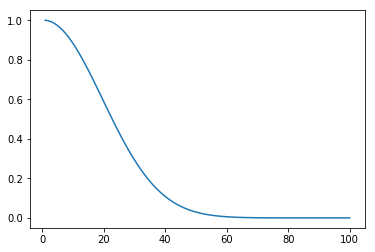

In [5]:
n=range(1,101)
d=zeros(100)
d[0]=1
for k in range(1,100):
    d[k]=d[k-1]*(365-k)/365
plt.plot(n,d,label='$d_n$')

Para $n=23$ se tiene $d_n = 0.4927 < 1/2$, por lo tanto para $n=23$ la probabilidad de que exista alguna colisión es mayor que $1/2$.

Nótese que $23$ es relativamente pequeño comparado con $365$, lo cual indica, en general, que no es necesario que $n$ sea muy grande en relación a $m$ para que sea probable que exista alguna colisión. Por otra parte, el número total de colisiones no puede ser muy grande, y ambos hechos son los que debemos tener en consideración al aplicar la idea de hashing al diseño de diccionarios.

### Métodos de resolución de colisiones

Dado que es inevitable que existan colisiones (aunque esperamos que sean pocas), debe haber alguna manera de resolver el problema que se produce cuando dos o más llaves son enviadas por la función de hashing al mismo casillero de la tabla.

Existen dos grandes familias de métodos:

* *Encadenamiento*: Utilizar punteros para enlazar los elementos que coinciden en su función de hashing.

* *Direccionamiento abierto (Open addressing)*: Utilizar una secuencia de funciones de hashing

## Hashing con Encadenamiento

La idea en este método es que todos los elementos que caen en el mismo lugar de la tabla se enlazan en una lista secuencial, y en cada casillero se almacena el puntero al inicio de la lista respectiva.

![encadenamiento](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/encadenamiento.gif?raw=1)

Para analizar la eficiencia de este método, recordemos que para un conjunto de $n$ llaves hemos definido $C_n$ y $C'_n$ como respectivamente el número esperado de comparaciones de llaves en una búsqueda exitosa y en una búsqueda infructuosa.

Si suponemos que $n$ llaves se lanzan al azar sobre una tabla de tamaño $m$, el número esperado de llaves por casillero es $n/m$, y eso es también el largo esperado de una lista aleatoria. En una búsqueda infructuosa hay que recorrer toda la lista, y por lo tanto tenemos que

$$
C'_n = \frac{n}{m}
$$

Para analizar el costo esperado de búsqueda exitosa $C_n$, consideremos las llaves en orden de inserción. Supongamos que hay $k$ llaves en la tabla e insertamos una más. El largo esperado de la lista en que le toca almacenarse es $k/m$, y supongamos que la nueva llave se agrega al final de su lista. Si ahora hacemos una búsqueda exitosa de llave recién insertada, su costo esperado de búsqueda será $1+k/m$. Para calcular el costo esperado de búsqueda exitosa sobre todas las llaves de la tabla, tenemos que sumar esos costos individuales y dividir por $n$:

$$
C_n = \frac{1}{n} \sum_{0\le k\le n-1} \left( 1 + C'_k \right) = \frac{1}{n} \sum_{0\le k\le n-1} \left( 1 + \frac{k}{m} \right) = 1 + \frac{n-1}{2m}
$$

Se define el *factor de carga de la tabla* $\alpha$ como el cuociente

$$
\alpha = \frac{n}{m}
$$

Se dice que una tabla está $\alpha$-llena si el cuociente $n/m$ se mantiene constante a medida que $n$ y $m$ crecen.

Para una tabla de hashing con encadenamiento que está $\alpha$-llena, se tiene que

$$
\begin{align}
C'_n & = \alpha \\
C_n & \approx 1+\frac{\alpha}{2}
\end{align}
$$

Esto ilustra un hecho que caracteriza a las tablas de hashing: cuando el factor de carga $\alpha$ se mantiene constante, los costos esperados de búsqueda son constantes, y no dependen de $n$ y $m$ por separado, sino de su cuociente $\alpha$.

Una debilidad de muchas tablas de hashing es que su peor caso puede ser muy malo. En el caso de las tablas de hashing con encadenamiento, el peor caso se da cuando todas las llaves caen en el mismo casillero, y en ese caso los costos de búsqueda serían $\Theta(n)$, porque la estructura degenera a una simple lista lineal.

Sin embargo, una buena función de hashing hace que ese peor caso sea extremadamente improbable, de modo que en la práctica no hay problema en confiar en que el costo observado será cercano al costo esperado que predice el modelo.

La *eliminación* de una llave es sencilla, porque basta desenlazarla de la lista en que se encuentra.

## Hashing con Direccionamiento abierto

Otra forma de resolver colisiones es disponer de una *secuencia* de funciones de hashing $\{ h_0(x), h_1(x),\ldots\}$, donde cada valor es distinto de todos los anteriores. Para insertar una nueva llave primero se prueba en el casillero $h_0(x)$, si está ocupado se intenta en $h_1(x)$ y así sucesivamente. Para hacer una búsqueda, se sigue el mismo itinerario.

Lo anterior en realidad define una familia de métodos, los cuales dependen de cómo se defina esa secuencia de funciones de hashing. A continuación veremos los dos más importantes.

## Linear Probing

Este es un método muy sencillo, que consiste en probar primero en el casillero $h(x)$, y si está ocupado, continuar buscando secuencialmente hacia la derecha, hasta encontrar un lugar libre. Si llegamos al extremo derecho de la tabla, continuamos en el extremo izquierdo, como si la tabla fuera circular.

Más formalmente, la secuencia de funciones de hashing se define como

$$
\begin{align}
h_0(x) & = h(x)\\
h_{i+1}(x) & = (h_i(x)+1) \bmod m
\end{align}
$$

![LinearProbing](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/LinearProbing.gif?raw=1)

---

### Ejercicio 6.3 (Inserciones en una tabla de hashing con Linear Probing)

Suponga que se tiene una tabla de hashing con Linear Probing, de tamaño 10, inicialmente vacía, con la función de hashing $h(x) = x \bmod 10$ (por ejemplo, $h(64)=4$). Muestre en la siguiente tabla el resultado de insertar (a mano) la siguiente secuencia de llaves:

```
34, 59, 45, 27, 14, 22, 75, 25
```

![EjercicioLinearProbing](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/EjercicioLinearProbing.png?raw=1)

Utilizaremos la siguiente función para ver si su respuesta está correcta:

In [22]:
def chequea_tabla(lista):
    h=0
    for x in lista:
        h = (h*100+x) % 100000007
    print("OK" if h==60375958 else "Error")

En el siguiente recuadro reemplace la lista de ceros por la lista de los elementos resultantes en la tabla. Si un casillero queda vacío, escriba un cero.

In [24]:
chequea_tabla([0,0,0,0,0,0,0,0,0,0])

Error


---

El análisis de este método de Linear Probing es complicado, por lo que solo daremos los resultados.

Para una tabla $\alpha$-llena, tenemos que

$$
\begin{align}
C'_n & \approx \frac{1}{2}\left(1+\frac{1}{(1-\alpha)^2} \right) \\
C_n & \approx \frac{1}{2}\left(1+\frac{1}{1-\alpha} \right)
\end{align}
$$

En el caso de una tabla llena ($\alpha\to 1$), estas fórmulas no nos sirven, porque los denominadores tienden a cero. Se puede hacer obtener fórmulas precisas para ese caso, esto es, para el caso $n=m$ cuando la búsqueda es exitosa, o $n=m-1$ para una búsqueda infructuosa o inserción (porque en ambos casos debe haber al menos un casillero vacío):

$$
\begin{align}
C'_{m-1} & = \Theta(m) \\
C_m & = \Theta(\sqrt{m})
\end{align}
$$

Cuando una tabla de hashing con Linear Probing se va acercando a estar llena, el método se vuelve muy lento:

$\alpha$ | $C_n$ | $C'_n$
--------|--------|-------
0.6 | 1.75 | 3.63
0.7 | 2.17 | 6.06
0.8 | 3.00 | 13.00
0.9 | 5.50 | 50.50
0.99 | 50.50 | 5000.50
0.999 | 500.50 | 500000.50

Si observamos la tabla a medida que se va llenando, veremos que empiezan a aparecer bloques (*clusters*) de casilleros ocupados.

![clusters](https://github.com/ivansipiran/CC3001-Apuntes/blob/main/recursos/clusters.gif?raw=1)

Idealmente, querríamos que los *clusters* fueran pequeños, porque así una llave que viene llegando necesita recorrer un camino corto hasta encontrar un casillero vacío. Pero en realidad ocurre todo lo contrario.
En efecto, si la función de hashing distribuye los elementos uniformemente dentro de la tabla, *la probabilidad que un cluster crezca es proporcional a su tamaño*. Esto implica que una mala situación se vuelve peor cada vez con mayor probabilidad. Sin embargo, este no es todo el problema. La situación empeora cuando dos clusters están separados solo por un casillero libre y ese casillero es ocupado por la llave entrante: ambos clusters se fusionan en uno mucho más grande.

Otro problema que surge con linear probing es conocido como *clustering secundario*: si al realizar la búsqueda de dos elementos en la tabla se encuentran con el mismo casillero ocupado, entonces toda la búsqueda subsiguiente es la misma para ambos elementos.

El peor caso de Linear Probings es muy malo, y también increíblemente improbable. Se da cuando todas las llaves colisionan en un solo casillero, y en ese caso la estructura degenera a una simple búsqueda secuencial, con costos de búsqueda $\Theta(n)$.

Respecto de la eliminación de elementos, es importante notar que no se puede eliminar un elemento y simplemente dejar su casillero vacío, puesto que las búsquedas terminarían en dicho casillero. Existen dos maneras para eliminar elementos de la tabla:

* Marcar el casillero como "eliminado", pero sin liberar el espacio (excepto cuando se necesita para una inserción). Esto produce que las búsquedas puedan ser lentas incluso si el factor de carga de la tabla es pequeño.
* Eliminar el elemento, liberar el casillero y mover elementos dentro de la tabla hasta que un casillero "verdaderamente" libre sea encontrado. Implementar esta operación es complejo y costoso.

## Hashing Doble

Este es un método que evita el problema del clustering secundario, reemplazándolo por clustering terciario, que afecta menos el desempeño.

La idea es generar la secuencia de funciones de hashing usando **dos** funciones de hashing independientes: $h(x)$ y $s(x)$ ("step"), tales que $h(x) \in [0..m-1]$ y $s(x) \in [1..m-1]$. Si el casillero $h(x)$ está ocupado, se intenta en $h(x)+s(x)$, $h(x)+2s(x)$ y así sucesivamente, todo esto módulo el tamaño de la tabla.

Más precisamente,

$$
\begin{align}
h_0(x) & = h(x)\\
h_{i+1}(x) & = (h_i(x)+s(x)) \bmod m
\end{align}
$$

Si $s(x)$ fuera mayor que 1 y divisor de $m$, la secuencia se repetiría después de $m/s(x)$ pasos, sin haber visitado todos los casilleros de la tabla. Para evitar esto, se debe escoger $m$ como un número **primo**.

El análisis exacto de la eficiencia de este método es muy complicado, pero se obtienen buenos resultados usando modelos idealizados, ya sea suponiendo que la tabla se recorre usando muestreo sin reemplazo (llamado *uniform probing*) o muestreo con reemplazo (llamado *random probing*). Bajo estos modelos, se obtiene que los costos esperados de búsqueda para una tabla $\alpha$-llena son:

$$
\begin{align}
C'_n & \approx \frac{1}{1-\alpha} \\
C_n & \approx \frac{1}{\alpha}\ln{\frac{1}{1-\alpha}}
\end{align}
$$

Para una tabla llena, tenemos:

$$
\begin{align}
C'_{m-1} & = \Theta(m) \\
C_m & = \Theta(\log{m})
\end{align}
$$

La siguiente tabla muestra que este método se desempeña mejor que Linear Probing desde el punto de vista del número esperado de comparaciones:

$\alpha$ | $C_n$ | $C'_n$
--------|--------|-------
0.6 | 1.53 | 2.50
0.7 | 1.72 | 3.33
0.8 | 2.01 | 5.00
0.9 | 2.56 | 10.00
0.99 | 4.65 | 100.00
0.999 | 6.91 | 1000.00

El peor caso de Hashing Doble es muy malo, pero incluso más improbable que el de Linear Probing. Se da cuando todas las llaves colisionan en un solo casillero y además todas tienen el mismo valor de $s(x)$, en cuyo caso la estructura degenera a una simple búsqueda secuencial, con costos de búsqueda $\Theta(n)$.

Respecto de las eliminaciones, la única posibilidad es marcar el elemento como "eliminado", con lo cual se considera ocupado para efecto de las búsquedas, pero libre para efectos de una inserción. Esto funciona, pero estos elementos contaminan la tabla y hacen que las búsquedas sean más lentas incluso cuando el factor de carga efectivo es bajo.

Cuando dos llaves colisionan, el método de inserción le da preferencia a la que llegó primero (a este método se le llama también *First-Come-First-Served*, o *FCFS*), pero en realidad cualquiera de las dos llaves podría ocupar el casillero en disputa, y la otra tendría que buscar en otro lugar.

A partir de esta observación, existen heurísticas para resolver el problema de las colisiones en hashing con direccionamiento abierto, como por ejemplo *Last-Come-First-Served* o *LCFS* hashing (el elemento que se mueve de casillero no es el que se inserta sino el que ya lo ocupaba) y *Robin Hood* hashing (el elemento que se queda en el casillero es aquel que se encuentre más lejos de su posición original), que si no cambian el promedio del costo de búsqueda con respecto al método original *FCFS*, sí disminuyen dramáticamente su varianza.